<a href="https://colab.research.google.com/github/bhatnira/Acetylcholinesterase-Inhibitor-Discovery/blob/main/deepNet_RDKit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rdkit Feature Based DeepNet Classification Modeling

## Introduction

Rdkit Features: RDKiT descriptor are easy to calculate descriptors open-sourced under rdkit.Chem.Descriptor modules by RDKit (Rdkit.Chem.Descriptors Module, 2024). Check out documentation here:  [Rdkit Descriptor Module](https://rdkit.org/docs/source/rdkit.Chem.Descriptors.html)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading and Preprocessing



### Data loading

Acquisition of the primary molecular dataset of the human acetylcholinesterase inhibitor was done from ChEMBL(ID:ChEMBL22). From 18,204 inhibitor entries, 4077 compounds with reported IC50 value and validated SMILE annotations were chosen, with redundant chemical structures resolved by randomly selecting one from the most frequently occurring activity label group. The resulting dataset comprises 2,330 instances labeled as positive and 1,747 instances labeled as negative. Molecules with an IC50 value less than 1uM were labeled as positives, and greater than 1 uM were labeled as negatives.  

In [ ]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/Part_2_standarizationOfMolecule/StandarizedSmiles_cutOFF800daltonMolecularweight.xlsx')
df.head(5)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,tSNE1,tSNE2,MolecularWeight,Frequency,cleanedMol
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,-52.761700,-42.736099,275.352,27,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,-63.027809,-53.765778,325.364,1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.0,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,-61.968063,-54.078575,263.293,1,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,57.758297,-8.911607,212.296,4,Cc1ccc2c(N)c3c(nc2c1)CCCC3
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,61.242554,5.783804,341.455,3,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2


In [ ]:
df.shape

(4077, 15)

In [ ]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 60.2 MB/s eta 0:00:00


### Descriptor generation and feature preparation
Two feature sets were created: one underwent LASSO treatment, which was employed in classical, ensemble, and deep learning models. The other set, devoid of LASSO treatment, was utilized in the AutoML method, as it incorporates its own feature processing and selection methodology within its pipeline.

The code for descriptor calculation was adopted form blogpost by [@greglandrum](https://https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html)

In [ ]:
# Importing pandas as pd
import pandas as pd

# Importing required modules from RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors

# Define a function to calculate the full list of descriptors for a molecule
def calculate_molecular_descriptors(molecule, missing_value=None):
    # Initialize an empty dictionary to store descriptor values
    result = {}

    # Iterate through the descriptor list and calculate descriptors for the molecule
    for name, function in Descriptors._descList:
        try:
            # Calculate descriptor value for the molecule
            value = function(molecule)
        except:
            # Print the error message
            import traceback
            traceback.print_exc()
            # Set the descriptor value to the specified missing value
            value = missing_value
        # Store the descriptor value in the result dictionary
        result[name] = value
    return result

# Define a list to store the computed descriptors for each molecule
descriptor_list = []

# Iterate through the SMILES column and calculate descriptors for each molecule
for smiles_string in df['cleanedMol']:
    # Convert SMILES string to RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles_string)

    # Check if the molecule is valid
    if molecule is not None:
        # Calculate descriptors using the calculate_molecular_descriptors function
        descriptors = calculate_molecular_descriptors(molecule, missing_value=None)

        # Add the descriptors to the list
        descriptor_list.append(descriptors)
    else:
        # Handle invalid or missing molecules if needed
        descriptor_list.append({})

# Convert the list of descriptors to a pandas DataFrame
descriptor_df = pd.DataFrame(descriptor_list)

# Merge the original DataFrame with the descriptor DataFrame
df = pd.concat([df, descriptor_df], axis=1)

In [ ]:
df.shape

(4077, 223)

In [ ]:
df.dropna(axis=1)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,229.08,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327c30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.478199,1.261641,...,0,0,0,0,0,0,0,0,0,0
4073,CHEMBL3906317,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],10000.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327ca0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.671263,-0.016301,...,0,0,0,0,0,0,0,0,0,0
4074,CHEMBL4800328,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],1080.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.586529,-0.433179,...,0,0,0,0,0,0,0,0,0,0
4075,CHEMBL4797670,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],140.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.677524,-0.748477,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
feature1=df.iloc[:, 15:]

In [ ]:
columns_with_nan = feature1.columns[feature1.isna().any()].tolist()

print(columns_with_nan)

['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']


In [ ]:
import pandas as pd
# Calculate the variability (variance) of each column
variances = feature1.var()

# Define a threshold for low variability
threshold = 0

# Identify columns with variability below the threshold
low_variability_columns = variances[variances == threshold].index

# Drop columns with low variability
feature1.drop(columns=low_variability_columns, inplace=True)

feature1


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.353370,-0.429125,11.353370,0.098109,0.848240,275.352,254.184,275.163377,108,0.411839,...,0,0,0,0,0,0,0,0,0,0
1,12.152013,-0.507704,12.152013,0.093140,0.906446,325.364,306.212,325.131408,124,0.416597,...,0,0,0,0,0,0,0,0,0,0
2,11.430389,-0.439927,11.430389,0.056694,0.888271,263.293,246.157,263.115758,102,0.412091,...,0,0,0,0,0,0,0,0,0,0
3,6.249844,0.958056,6.249844,0.958056,0.728716,212.296,196.168,212.131349,82,0.072836,...,0,0,0,0,0,0,0,0,0,0
4,11.077636,-0.345833,11.077636,0.112292,0.396155,341.455,314.239,341.210327,134,0.271131,...,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,13.153269,-1.144692,13.153269,0.039314,0.390527,449.463,426.279,449.158685,170,0.308243,...,0,0,0,0,0,0,0,0,0,0
4073,13.179451,-4.369559,13.179451,0.172737,0.762966,306.307,291.187,306.110025,114,0.422266,...,0,0,0,0,0,0,0,0,0,0
4074,5.424113,0.901816,5.424113,0.901816,0.635009,250.321,234.193,250.122641,94,0.210146,...,0,0,0,0,0,0,0,0,0,0
4075,5.421510,0.854370,5.421510,0.854370,0.679519,266.320,250.192,266.117555,100,0.210400,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
columns_with_nan = feature1.columns[feature1.isna().any()].tolist()
print(columns_with_nan)

['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']


In [ ]:
target=df['classLabel']
target.head()

0    1
1    1
2    0
3    1
4    1
Name: classLabel, dtype: int64

In [ ]:
column_name_to_drop = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']
feature1 = feature1.drop(columns=column_name_to_drop)
feature1

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan1,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.353370,-0.429125,11.353370,0.098109,0.848240,275.352,254.184,275.163377,108,1.450000,...,0,0,0,0,0,0,0,0,0,0
1,12.152013,-0.507704,12.152013,0.093140,0.906446,325.364,306.212,325.131408,124,1.291667,...,0,0,0,0,0,0,0,0,0,0
2,11.430389,-0.439927,11.430389,0.056694,0.888271,263.293,246.157,263.115758,102,1.578947,...,0,0,0,0,0,0,0,0,0,0
3,6.249844,0.958056,6.249844,0.958056,0.728716,212.296,196.168,212.131349,82,1.187500,...,0,0,0,0,0,0,0,0,0,0
4,11.077636,-0.345833,11.077636,0.112292,0.396155,341.455,314.239,341.210327,134,1.160000,...,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,13.153269,-1.144692,13.153269,0.039314,0.390527,449.463,426.279,449.158685,170,0.909091,...,0,0,0,0,0,0,0,0,0,0
4073,13.179451,-4.369559,13.179451,0.172737,0.762966,306.307,291.187,306.110025,114,1.045455,...,0,0,0,0,0,0,0,0,0,0
4074,5.424113,0.901816,5.424113,0.901816,0.635009,250.321,234.193,250.122641,94,0.947368,...,0,0,0,0,0,0,0,0,0,0
4075,5.421510,0.854370,5.421510,0.854370,0.679519,266.320,250.192,266.117555,100,0.850000,...,0,0,0,0,0,0,0,0,0,0


### Feature Selection

In [ ]:
# Importing necessary libraries
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(feature1)
# Lasso model with cross-validated alpha selection
lasso_model = LassoCV(cv=5)
# Fit the Lasso model to the standardized feature matrix (X) and the target variable ('classLabel')
lasso_model.fit(X, df['classLabel'])
# Get the selected features based on the coefficients obtained from Lasso regularization
selected_features = feature1.columns[lasso_model.coef_ != 0]
# Create a new feature dataframe containing only the selected features
feature_dataframe = feature1[selected_features]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08395803603184504, tolerance: 0.07976602269242558
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21921629724164404, tolerance: 0.07976602269242558
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3324164918406609, tolerance: 0.07976602269242558
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Con

In [ ]:
import pandas as pd
import numpy as np

## Classification modeling with deepnet architectures: ANN, CNN, LSTM, GRU, BiLSTM


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, GRU, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef,
    roc_auc_score,
)

# Define a function to print the confusion matrix as text
def print_confusion_matrix(confusion, model_name):
    print(f"Confusion Matrix - {model_name}:")
    for row in confusion:
        print(row)
# Use StandardScaler to scale your features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_dataframe)
# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=42)

# Reshape input data for LSTM and Bi-LSTM models
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid_lstm = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the number of classes
num_classes = 2

# Define deep learning models
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model = Sequential([
    Conv1D(128, 5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(5),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

lstm_model = Sequential([
    LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

gru_model = Sequential([
    GRU(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

bi_lstm_model = Sequential([
    Bidirectional(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the models
for model in [ann_model, cnn_model, lstm_model, gru_model, bi_lstm_model]:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train, evaluate, and store results
results = {'Model': [], 'Validation Accuracy': [], 'Test Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [],
           'ROC-AUC': [], 'Cohen\'s Kappa': [], 'MCC': []}
for model_name, model in [('ANN', ann_model), ('CNN', cnn_model), ('LSTM', lstm_model), ('GRU', gru_model), ('Bi-LSTM', bi_lstm_model)]:
    # Define early stopping callback based on recall
    early_stopping = EarlyStopping(monitor='val_recall', mode='max', patience=5, restore_best_weights=True)

    # Train the model
    if model_name in ['LSTM', 'GRU', 'Bi-LSTM']:
        history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_data=(X_valid_lstm, y_valid),
                            callbacks=[early_stopping])
    else:
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid),
                            callbacks=[early_stopping])

    # Evaluate the model
    if model_name in ['LSTM', 'GRU', 'Bi-LSTM']:
        y_valid_pred_prob = model.predict(X_valid_lstm)
        y_test_pred_prob = model.predict(X_test_lstm)
    else:
        y_valid_pred_prob = model.predict(X_valid)
        y_test_pred_prob = model.predict(X_test)

    y_valid_pred = np.argmax(y_valid_pred_prob, axis=1)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)

    # Calculate evaluation metrics
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Calculate the confusion matrix
    confusion = confusion_matrix(y_test, y_test_pred)

    # Print the confusion matrix as text
    print_confusion_matrix(confusion, model_name)

    # Print evaluation metrics
    print(f"Model: {model_name}")
    print("Validation Accuracy:", valid_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC-AUC Score:", roc_auc)
    print("Cohen's Kappa Score:", cohen_kappa)
    print("MCC Score:", mcc)
    print()

    # Store results
    results['Model'].append(model_name)
    results['Validation Accuracy'].append(valid_accuracy)
    results['Test Accuracy'].append(test_accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)


Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 0.8201 - accuracy: 0.5482

90/90 [==============================] - 3s 6ms/step - loss: 0.8201 - accuracy: 0.5482 - val_loss: 0.6533 - val_accuracy: 0.6487
Epoch 2/100
73/90 [=======================>......] - ETA: 0s - loss: 0.6883 - accuracy: 0.5865

90/90 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5903 - val_loss: 0.6336 - val_accuracy: 0.6863
Epoch 3/100
74/90 [=======================>......] - ETA: 0s - loss: 0.6273 - accuracy: 0.6356

90/90 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6435 - val_loss: 0.6111 - val_accuracy: 0.6879
Epoch 4/100
74/90 [=======================>......] - ETA: 0s - loss: 0.6032 - accuracy: 0.6753

90/90 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.6786 - val_loss: 0.5952 - val_accuracy: 0.7157
Epoch 5/100
73/90 [=======================>......] - ETA: 0s - loss: 0.5939 - accuracy: 0.6742

90/90 [==============================] - 0s 3ms/step - loss: 0.5867 - accuracy: 0.6828 - val_loss: 0.5810 - val_accuracy: 0.7239
Epoch 6/100
87/90 [============================>.] - ETA: 0s - loss: 0.5780 - accuracy: 0.6972

90/90 [==============================] - 0s 4ms/step - loss: 0.5772 - accuracy: 0.6972 - val_loss: 0.5691 - val_accuracy: 0.7369
Epoch 7/100
74/90 [=======================>......] - ETA: 0s - loss: 0.5371 - accuracy: 0.7259

90/90 [==============================] - 0s 3ms/step - loss: 0.5411 - accuracy: 0.7245 - val_loss: 0.5528 - val_accuracy: 0.7451
Epoch 8/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5277 - accuracy: 0.7318

90/90 [==============================] - 0s 4ms/step - loss: 0.5267 - accuracy: 0.7326 - val_loss: 0.5428 - val_accuracy: 0.7598
Epoch 9/100
73/90 [=======================>......] - ETA: 0s - loss: 0.5109 - accuracy: 0.7607

90/90 [==============================] - 0s 4ms/step - loss: 0.5184 - accuracy: 0.7543 - val_loss: 0.5262 - val_accuracy: 0.7598
Epoch 10/100
88/90 [============================>.] - ETA: 0s - loss: 0.5006 - accuracy: 0.7685

90/90 [==============================] - 0s 4ms/step - loss: 0.4996 - accuracy: 0.7690 - val_loss: 0.5254 - val_accuracy: 0.7712
Epoch 11/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4881 - accuracy: 0.7743

90/90 [==============================] - 0s 4ms/step - loss: 0.4861 - accuracy: 0.7764 - val_loss: 0.5168 - val_accuracy: 0.7778
Epoch 12/100
88/90 [============================>.] - ETA: 0s - loss: 0.4677 - accuracy: 0.7915

90/90 [==============================] - 0s 4ms/step - loss: 0.4693 - accuracy: 0.7907 - val_loss: 0.5122 - val_accuracy: 0.7729
Epoch 13/100
87/90 [============================>.] - ETA: 0s - loss: 0.4700 - accuracy: 0.7877

90/90 [==============================] - 0s 4ms/step - loss: 0.4694 - accuracy: 0.7890 - val_loss: 0.5063 - val_accuracy: 0.7794
Epoch 14/100
84/90 [===========================>..] - ETA: 0s - loss: 0.4565 - accuracy: 0.8017

90/90 [==============================] - 0s 4ms/step - loss: 0.4563 - accuracy: 0.8030 - val_loss: 0.5008 - val_accuracy: 0.7892
Epoch 15/100
74/90 [=======================>......] - ETA: 0s - loss: 0.4389 - accuracy: 0.8087

90/90 [==============================] - 0s 3ms/step - loss: 0.4414 - accuracy: 0.8058 - val_loss: 0.4937 - val_accuracy: 0.7876
Epoch 16/100
74/90 [=======================>......] - ETA: 0s - loss: 0.4380 - accuracy: 0.8104

90/90 [==============================] - 0s 3ms/step - loss: 0.4362 - accuracy: 0.8107 - val_loss: 0.4928 - val_accuracy: 0.7941
Epoch 17/100
73/90 [=======================>......] - ETA: 0s - loss: 0.4135 - accuracy: 0.8181

90/90 [==============================] - 0s 3ms/step - loss: 0.4082 - accuracy: 0.8219 - val_loss: 0.4899 - val_accuracy: 0.8007
Epoch 18/100
74/90 [=======================>......] - ETA: 0s - loss: 0.4186 - accuracy: 0.8150

90/90 [==============================] - 0s 3ms/step - loss: 0.4244 - accuracy: 0.8100 - val_loss: 0.4944 - val_accuracy: 0.7974
Epoch 19/100
75/90 [========================>.....] - ETA: 0s - loss: 0.4122 - accuracy: 0.8229

90/90 [==============================] - 0s 3ms/step - loss: 0.4044 - accuracy: 0.8265 - val_loss: 0.4885 - val_accuracy: 0.7990
Epoch 20/100
74/90 [=======================>......] - ETA: 0s - loss: 0.3971 - accuracy: 0.8197

90/90 [==============================] - 0s 3ms/step - loss: 0.3994 - accuracy: 0.8205 - val_loss: 0.4938 - val_accuracy: 0.8007
Epoch 21/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4055 - accuracy: 0.8278

90/90 [==============================] - 0s 4ms/step - loss: 0.4029 - accuracy: 0.8283 - val_loss: 0.4818 - val_accuracy: 0.8088
Epoch 22/100
74/90 [=======================>......] - ETA: 0s - loss: 0.3976 - accuracy: 0.8336

90/90 [==============================] - 0s 3ms/step - loss: 0.4023 - accuracy: 0.8275 - val_loss: 0.4799 - val_accuracy: 0.8088
Epoch 23/100
90/90 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8360

90/90 [==============================] - 0s 4ms/step - loss: 0.3907 - accuracy: 0.8360 - val_loss: 0.4844 - val_accuracy: 0.8023
Epoch 24/100
75/90 [========================>.....] - ETA: 0s - loss: 0.3886 - accuracy: 0.8400

90/90 [==============================] - 0s 3ms/step - loss: 0.3876 - accuracy: 0.8391 - val_loss: 0.4795 - val_accuracy: 0.8007
Epoch 25/100
74/90 [=======================>......] - ETA: 0s - loss: 0.3763 - accuracy: 0.8425

90/90 [==============================] - 0s 3ms/step - loss: 0.3847 - accuracy: 0.8356 - val_loss: 0.4800 - val_accuracy: 0.8056
Epoch 26/100
75/90 [========================>.....] - ETA: 0s - loss: 0.3706 - accuracy: 0.8408

90/90 [==============================] - 0s 3ms/step - loss: 0.3729 - accuracy: 0.8437 - val_loss: 0.4822 - val_accuracy: 0.8039
Epoch 27/100
74/90 [=======================>......] - ETA: 0s - loss: 0.3632 - accuracy: 0.8467

90/90 [==============================] - 0s 3ms/step - loss: 0.3593 - accuracy: 0.8496 - val_loss: 0.4928 - val_accuracy: 0.8072
Epoch 28/100
73/90 [=======================>......] - ETA: 0s - loss: 0.3620 - accuracy: 0.8476

90/90 [==============================] - 0s 3ms/step - loss: 0.3587 - accuracy: 0.8521 - val_loss: 0.4948 - val_accuracy: 0.8105
Epoch 29/100
73/90 [=======================>......] - ETA: 0s - loss: 0.3495 - accuracy: 0.8609

90/90 [==============================] - 0s 3ms/step - loss: 0.3569 - accuracy: 0.8566 - val_loss: 0.4868 - val_accuracy: 0.7974
Epoch 30/100
90/90 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.8594

90/90 [==============================] - 0s 3ms/step - loss: 0.3468 - accuracy: 0.8594 - val_loss: 0.4971 - val_accuracy: 0.7958
Epoch 31/100
90/90 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8580

90/90 [==============================] - 0s 4ms/step - loss: 0.3455 - accuracy: 0.8580 - val_loss: 0.5013 - val_accuracy: 0.8056
Epoch 32/100
73/90 [=======================>......] - ETA: 0s - loss: 0.3411 - accuracy: 0.8669

90/90 [==============================] - 0s 4ms/step - loss: 0.3467 - accuracy: 0.8623 - val_loss: 0.4946 - val_accuracy: 0.8072
Epoch 33/100
73/90 [=======================>......] - ETA: 0s - loss: 0.3344 - accuracy: 0.8523

90/90 [==============================] - 0s 3ms/step - loss: 0.3367 - accuracy: 0.8535 - val_loss: 0.5148 - val_accuracy: 0.7892
Epoch 34/100
75/90 [========================>.....] - ETA: 0s - loss: 0.3181 - accuracy: 0.8692

90/90 [==============================] - 0s 3ms/step - loss: 0.3144 - accuracy: 0.8710 - val_loss: 0.5157 - val_accuracy: 0.8121
Epoch 35/100
73/90 [=======================>......] - ETA: 0s - loss: 0.3246 - accuracy: 0.8724

90/90 [==============================] - 0s 3ms/step - loss: 0.3290 - accuracy: 0.8703 - val_loss: 0.5166 - val_accuracy: 0.8235
Epoch 36/100
73/90 [=======================>......] - ETA: 0s - loss: 0.3166 - accuracy: 0.8669

90/90 [==============================] - 0s 3ms/step - loss: 0.3164 - accuracy: 0.8672 - val_loss: 0.5122 - val_accuracy: 0.8088
Epoch 37/100
73/90 [=======================>......] - ETA: 0s - loss: 0.2984 - accuracy: 0.8754

90/90 [==============================] - 0s 3ms/step - loss: 0.3062 - accuracy: 0.8714 - val_loss: 0.5297 - val_accuracy: 0.8056
Epoch 38/100
90/90 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8693

90/90 [==============================] - 0s 3ms/step - loss: 0.3308 - accuracy: 0.8693 - val_loss: 0.5054 - val_accuracy: 0.8039
Epoch 39/100
73/90 [=======================>......] - ETA: 0s - loss: 0.3099 - accuracy: 0.8716

90/90 [==============================] - 0s 3ms/step - loss: 0.3176 - accuracy: 0.8672 - val_loss: 0.4912 - val_accuracy: 0.8105
Epoch 40/100
73/90 [=======================>......] - ETA: 0s - loss: 0.3214 - accuracy: 0.8801

90/90 [==============================] - 0s 3ms/step - loss: 0.3230 - accuracy: 0.8777 - val_loss: 0.5136 - val_accuracy: 0.8186
Epoch 41/100
74/90 [=======================>......] - ETA: 0s - loss: 0.3071 - accuracy: 0.8657

90/90 [==============================] - 0s 3ms/step - loss: 0.3152 - accuracy: 0.8647 - val_loss: 0.5024 - val_accuracy: 0.8137
Epoch 42/100
85/90 [===========================>..] - ETA: 0s - loss: 0.3109 - accuracy: 0.8768

90/90 [==============================] - 0s 4ms/step - loss: 0.3108 - accuracy: 0.8763 - val_loss: 0.5230 - val_accuracy: 0.8170
Epoch 43/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2976 - accuracy: 0.8766

90/90 [==============================] - 0s 3ms/step - loss: 0.2981 - accuracy: 0.8745 - val_loss: 0.5308 - val_accuracy: 0.8105
Epoch 44/100
75/90 [========================>.....] - ETA: 0s - loss: 0.2999 - accuracy: 0.8783

90/90 [==============================] - 0s 3ms/step - loss: 0.3084 - accuracy: 0.8756 - val_loss: 0.5310 - val_accuracy: 0.8088
Epoch 45/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2922 - accuracy: 0.8832

90/90 [==============================] - 0s 3ms/step - loss: 0.2928 - accuracy: 0.8787 - val_loss: 0.5550 - val_accuracy: 0.8072
Epoch 46/100
75/90 [========================>.....] - ETA: 0s - loss: 0.2801 - accuracy: 0.8863

90/90 [==============================] - 0s 3ms/step - loss: 0.2817 - accuracy: 0.8847 - val_loss: 0.5688 - val_accuracy: 0.8137
Epoch 47/100
87/90 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.8858

90/90 [==============================] - 0s 4ms/step - loss: 0.2920 - accuracy: 0.8864 - val_loss: 0.5435 - val_accuracy: 0.8154
Epoch 48/100
88/90 [============================>.] - ETA: 0s - loss: 0.2927 - accuracy: 0.8771

90/90 [==============================] - 0s 4ms/step - loss: 0.2924 - accuracy: 0.8773 - val_loss: 0.5711 - val_accuracy: 0.8154
Epoch 49/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2820 - accuracy: 0.8877

90/90 [==============================] - 0s 4ms/step - loss: 0.2825 - accuracy: 0.8878 - val_loss: 0.5790 - val_accuracy: 0.8088
Epoch 50/100
73/90 [=======================>......] - ETA: 0s - loss: 0.2816 - accuracy: 0.8861

90/90 [==============================] - 0s 3ms/step - loss: 0.2859 - accuracy: 0.8829 - val_loss: 0.5670 - val_accuracy: 0.8235
Epoch 51/100
89/90 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.8848

90/90 [==============================] - 0s 4ms/step - loss: 0.2856 - accuracy: 0.8847 - val_loss: 0.5670 - val_accuracy: 0.8056
Epoch 52/100
87/90 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.8858

90/90 [==============================] - 0s 4ms/step - loss: 0.2732 - accuracy: 0.8868 - val_loss: 0.5834 - val_accuracy: 0.8007
Epoch 53/100
83/90 [==========================>...] - ETA: 0s - loss: 0.2798 - accuracy: 0.8818

90/90 [==============================] - 0s 4ms/step - loss: 0.2768 - accuracy: 0.8847 - val_loss: 0.5749 - val_accuracy: 0.8105
Epoch 54/100
74/90 [=======================>......] - ETA: 0s - loss: 0.2557 - accuracy: 0.8940

90/90 [==============================] - 0s 3ms/step - loss: 0.2544 - accuracy: 0.8959 - val_loss: 0.6058 - val_accuracy: 0.8039
Epoch 55/100
75/90 [========================>.....] - ETA: 0s - loss: 0.2638 - accuracy: 0.8929

90/90 [==============================] - 0s 3ms/step - loss: 0.2602 - accuracy: 0.8962 - val_loss: 0.5718 - val_accuracy: 0.8154
Epoch 56/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2552 - accuracy: 0.8939

90/90 [==============================] - 0s 3ms/step - loss: 0.2599 - accuracy: 0.8941 - val_loss: 0.5728 - val_accuracy: 0.8203
Epoch 57/100
77/90 [========================>.....] - ETA: 0s - loss: 0.2750 - accuracy: 0.8823

90/90 [==============================] - 0s 3ms/step - loss: 0.2700 - accuracy: 0.8864 - val_loss: 0.5609 - val_accuracy: 0.8121
Epoch 58/100
74/90 [=======================>......] - ETA: 0s - loss: 0.2438 - accuracy: 0.8974

90/90 [==============================] - 0s 3ms/step - loss: 0.2441 - accuracy: 0.8977 - val_loss: 0.6222 - val_accuracy: 0.8170
Epoch 59/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2673 - accuracy: 0.8972

90/90 [==============================] - 0s 3ms/step - loss: 0.2630 - accuracy: 0.8984 - val_loss: 0.5743 - val_accuracy: 0.8039
Epoch 60/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2558 - accuracy: 0.9013

90/90 [==============================] - 0s 3ms/step - loss: 0.2492 - accuracy: 0.9026 - val_loss: 0.5858 - val_accuracy: 0.8105
Epoch 61/100
90/90 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.8952

90/90 [==============================] - 0s 3ms/step - loss: 0.2594 - accuracy: 0.8952 - val_loss: 0.6029 - val_accuracy: 0.8105
Epoch 62/100
73/90 [=======================>......] - ETA: 0s - loss: 0.2539 - accuracy: 0.8964

90/90 [==============================] - 0s 3ms/step - loss: 0.2538 - accuracy: 0.8959 - val_loss: 0.5941 - val_accuracy: 0.8056
Epoch 63/100
77/90 [========================>.....] - ETA: 0s - loss: 0.2504 - accuracy: 0.8916

90/90 [==============================] - 0s 3ms/step - loss: 0.2541 - accuracy: 0.8906 - val_loss: 0.5931 - val_accuracy: 0.8105
Epoch 64/100
74/90 [=======================>......] - ETA: 0s - loss: 0.2298 - accuracy: 0.8999

90/90 [==============================] - 0s 3ms/step - loss: 0.2372 - accuracy: 0.8991 - val_loss: 0.6152 - val_accuracy: 0.8088
Epoch 65/100
75/90 [========================>.....] - ETA: 0s - loss: 0.2317 - accuracy: 0.9083

90/90 [==============================] - 0s 3ms/step - loss: 0.2311 - accuracy: 0.9085 - val_loss: 0.6694 - val_accuracy: 0.8121
Epoch 66/100
74/90 [=======================>......] - ETA: 0s - loss: 0.2589 - accuracy: 0.8953

90/90 [==============================] - 0s 3ms/step - loss: 0.2546 - accuracy: 0.8952 - val_loss: 0.6143 - val_accuracy: 0.8072
Epoch 67/100
75/90 [========================>.....] - ETA: 0s - loss: 0.2284 - accuracy: 0.9046

90/90 [==============================] - 0s 3ms/step - loss: 0.2289 - accuracy: 0.9061 - val_loss: 0.6359 - val_accuracy: 0.8121
Epoch 68/100
74/90 [=======================>......] - ETA: 0s - loss: 0.2497 - accuracy: 0.8995

90/90 [==============================] - 0s 3ms/step - loss: 0.2575 - accuracy: 0.8991 - val_loss: 0.5873 - val_accuracy: 0.8186
Epoch 69/100
75/90 [========================>.....] - ETA: 0s - loss: 0.2350 - accuracy: 0.9046

90/90 [==============================] - 0s 3ms/step - loss: 0.2380 - accuracy: 0.9043 - val_loss: 0.6305 - val_accuracy: 0.8219
Epoch 70/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2287 - accuracy: 0.9161

90/90 [==============================] - 0s 3ms/step - loss: 0.2241 - accuracy: 0.9155 - val_loss: 0.6540 - val_accuracy: 0.8203
Epoch 71/100
90/90 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9012

90/90 [==============================] - 0s 3ms/step - loss: 0.2474 - accuracy: 0.9012 - val_loss: 0.6559 - val_accuracy: 0.8072
Epoch 72/100
90/90 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9068

90/90 [==============================] - 0s 4ms/step - loss: 0.2307 - accuracy: 0.9068 - val_loss: 0.6397 - val_accuracy: 0.8235
Epoch 73/100
74/90 [=======================>......] - ETA: 0s - loss: 0.2335 - accuracy: 0.9101

90/90 [==============================] - 0s 3ms/step - loss: 0.2360 - accuracy: 0.9092 - val_loss: 0.6337 - val_accuracy: 0.8088
Epoch 74/100
74/90 [=======================>......] - ETA: 0s - loss: 0.2282 - accuracy: 0.9062

90/90 [==============================] - 0s 3ms/step - loss: 0.2323 - accuracy: 0.9047 - val_loss: 0.6660 - val_accuracy: 0.8121
Epoch 75/100
75/90 [========================>.....] - ETA: 0s - loss: 0.2218 - accuracy: 0.9108

90/90 [==============================] - 0s 3ms/step - loss: 0.2244 - accuracy: 0.9103 - val_loss: 0.6601 - val_accuracy: 0.8203
Epoch 76/100
73/90 [=======================>......] - ETA: 0s - loss: 0.2284 - accuracy: 0.9037

90/90 [==============================] - 0s 3ms/step - loss: 0.2267 - accuracy: 0.9071 - val_loss: 0.6615 - val_accuracy: 0.8105
Epoch 77/100
75/90 [========================>.....] - ETA: 0s - loss: 0.2141 - accuracy: 0.9187

90/90 [==============================] - 0s 3ms/step - loss: 0.2196 - accuracy: 0.9155 - val_loss: 0.6829 - val_accuracy: 0.8105
Epoch 78/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2262 - accuracy: 0.9137

90/90 [==============================] - 0s 3ms/step - loss: 0.2258 - accuracy: 0.9141 - val_loss: 0.6584 - val_accuracy: 0.8219
Epoch 79/100
74/90 [=======================>......] - ETA: 0s - loss: 0.2106 - accuracy: 0.9164

90/90 [==============================] - 0s 3ms/step - loss: 0.2115 - accuracy: 0.9152 - val_loss: 0.7165 - val_accuracy: 0.8121
Epoch 80/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2024 - accuracy: 0.9211

90/90 [==============================] - 0s 3ms/step - loss: 0.2119 - accuracy: 0.9173 - val_loss: 0.6831 - val_accuracy: 0.8088
Epoch 81/100
73/90 [=======================>......] - ETA: 0s - loss: 0.2070 - accuracy: 0.9182

90/90 [==============================] - 0s 3ms/step - loss: 0.2066 - accuracy: 0.9194 - val_loss: 0.7404 - val_accuracy: 0.8105
Epoch 82/100
77/90 [========================>.....] - ETA: 0s - loss: 0.2161 - accuracy: 0.9136

90/90 [==============================] - 0s 3ms/step - loss: 0.2169 - accuracy: 0.9138 - val_loss: 0.7102 - val_accuracy: 0.8121
Epoch 83/100
75/90 [========================>.....] - ETA: 0s - loss: 0.2169 - accuracy: 0.9150

90/90 [==============================] - 0s 3ms/step - loss: 0.2162 - accuracy: 0.9141 - val_loss: 0.7046 - val_accuracy: 0.8137
Epoch 84/100
73/90 [=======================>......] - ETA: 0s - loss: 0.2150 - accuracy: 0.9170

90/90 [==============================] - 0s 3ms/step - loss: 0.2185 - accuracy: 0.9152 - val_loss: 0.7114 - val_accuracy: 0.8170
Epoch 85/100
74/90 [=======================>......] - ETA: 0s - loss: 0.2230 - accuracy: 0.9160

90/90 [==============================] - 0s 3ms/step - loss: 0.2265 - accuracy: 0.9138 - val_loss: 0.6804 - val_accuracy: 0.8088
Epoch 86/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2122 - accuracy: 0.9169

90/90 [==============================] - 0s 3ms/step - loss: 0.2143 - accuracy: 0.9162 - val_loss: 0.6932 - val_accuracy: 0.8137
Epoch 87/100
87/90 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9185

90/90 [==============================] - 0s 4ms/step - loss: 0.2041 - accuracy: 0.9173 - val_loss: 0.7333 - val_accuracy: 0.8105
Epoch 88/100
90/90 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9106

90/90 [==============================] - 0s 4ms/step - loss: 0.2161 - accuracy: 0.9106 - val_loss: 0.6882 - val_accuracy: 0.8072
Epoch 89/100
88/90 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9205

90/90 [==============================] - 0s 4ms/step - loss: 0.2081 - accuracy: 0.9211 - val_loss: 0.7313 - val_accuracy: 0.8186
Epoch 90/100
88/90 [============================>.] - ETA: 0s - loss: 0.2012 - accuracy: 0.9201

90/90 [==============================] - 0s 4ms/step - loss: 0.2038 - accuracy: 0.9194 - val_loss: 0.7388 - val_accuracy: 0.8170
Epoch 91/100
90/90 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9155

90/90 [==============================] - 0s 4ms/step - loss: 0.1975 - accuracy: 0.9155 - val_loss: 0.7791 - val_accuracy: 0.8170
Epoch 92/100
88/90 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.9165

90/90 [==============================] - 0s 4ms/step - loss: 0.2027 - accuracy: 0.9166 - val_loss: 0.8245 - val_accuracy: 0.8137
Epoch 93/100
85/90 [===========================>..] - ETA: 0s - loss: 0.2147 - accuracy: 0.9125

90/90 [==============================] - 0s 4ms/step - loss: 0.2145 - accuracy: 0.9124 - val_loss: 0.7160 - val_accuracy: 0.8137
Epoch 94/100
75/90 [========================>.....] - ETA: 0s - loss: 0.1711 - accuracy: 0.9237

90/90 [==============================] - 0s 3ms/step - loss: 0.1847 - accuracy: 0.9159 - val_loss: 0.7855 - val_accuracy: 0.8170
Epoch 95/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1908 - accuracy: 0.9202

90/90 [==============================] - 0s 3ms/step - loss: 0.1903 - accuracy: 0.9211 - val_loss: 0.7646 - val_accuracy: 0.8235
Epoch 96/100
77/90 [========================>.....] - ETA: 0s - loss: 0.1942 - accuracy: 0.9245

90/90 [==============================] - 0s 3ms/step - loss: 0.1994 - accuracy: 0.9229 - val_loss: 0.7236 - val_accuracy: 0.8186
Epoch 97/100
77/90 [========================>.....] - ETA: 0s - loss: 0.2050 - accuracy: 0.9164

90/90 [==============================] - 0s 3ms/step - loss: 0.1944 - accuracy: 0.9201 - val_loss: 0.7941 - val_accuracy: 0.8056
Epoch 98/100
77/90 [========================>.....] - ETA: 0s - loss: 0.1842 - accuracy: 0.9261

90/90 [==============================] - 0s 3ms/step - loss: 0.1909 - accuracy: 0.9243 - val_loss: 0.7901 - val_accuracy: 0.8137
Epoch 99/100
77/90 [========================>.....] - ETA: 0s - loss: 0.1894 - accuracy: 0.9221

90/90 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.9225 - val_loss: 0.7695 - val_accuracy: 0.8284
Epoch 100/100
75/90 [========================>.....] - ETA: 0s - loss: 0.1842 - accuracy: 0.9271

20/20 [==============================] - 0s 1ms/step
Confusion Matrix - ANN:
[308  56]
[ 32 216]
Model: ANN
Validation Accuracy: 0.8104575163398693
Test Accuracy: 0.8562091503267973
Precision: 0.7941176470588235
Recall: 0.8709677419354839
F1 Score: 0.8307692307692308
ROC-AUC Score: 0.858560794044665
Cohen's Kappa Score: 0.7062314540059347
MCC Score: 0.708509076626779

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.5450

90/90 [==============================] - 4s 8ms/step - loss: 0.6885 - accuracy: 0.5450 - val_loss: 0.6601 - val_accuracy: 0.5948
Epoch 2/100
87/90 [============================>.] - ETA: 0s - loss: 0.6727 - accuracy: 0.5769

90/90 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.5766 - val_loss: 0.6453 - val_accuracy: 0.6160
Epoch 3/100
76/90 [========================>.....] - ETA: 0s - loss: 0.6566 - accuracy: 0.6032

90/90 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.6071 - val_loss: 0.6329 - val_accuracy: 0.6748
Epoch 4/100
76/90 [========================>.....] - ETA: 0s - loss: 0.6267 - accuracy: 0.6579

90/90 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6519 - val_loss: 0.6409 - val_accuracy: 0.6062
Epoch 5/100
86/90 [===========================>..] - ETA: 0s - loss: 0.6184 - accuracy: 0.6711

90/90 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6730 - val_loss: 0.6023 - val_accuracy: 0.6961
Epoch 6/100
88/90 [============================>.] - ETA: 0s - loss: 0.5914 - accuracy: 0.6942

90/90 [==============================] - 0s 4ms/step - loss: 0.5919 - accuracy: 0.6937 - val_loss: 0.5785 - val_accuracy: 0.7157
Epoch 7/100
76/90 [========================>.....] - ETA: 0s - loss: 0.5804 - accuracy: 0.7015

90/90 [==============================] - 0s 4ms/step - loss: 0.5827 - accuracy: 0.7024 - val_loss: 0.6071 - val_accuracy: 0.6552
Epoch 8/100
76/90 [========================>.....] - ETA: 0s - loss: 0.5420 - accuracy: 0.7360

90/90 [==============================] - 0s 4ms/step - loss: 0.5459 - accuracy: 0.7368 - val_loss: 0.5606 - val_accuracy: 0.7239
Epoch 9/100
89/90 [============================>.] - ETA: 0s - loss: 0.5255 - accuracy: 0.7525

90/90 [==============================] - 0s 4ms/step - loss: 0.5251 - accuracy: 0.7529 - val_loss: 0.5430 - val_accuracy: 0.7402
Epoch 10/100
76/90 [========================>.....] - ETA: 0s - loss: 0.5347 - accuracy: 0.7467

90/90 [==============================] - 0s 4ms/step - loss: 0.5312 - accuracy: 0.7511 - val_loss: 0.5143 - val_accuracy: 0.7565
Epoch 11/100
78/90 [=========================>....] - ETA: 0s - loss: 0.4864 - accuracy: 0.7873

90/90 [==============================] - 0s 5ms/step - loss: 0.4851 - accuracy: 0.7848 - val_loss: 0.5742 - val_accuracy: 0.7353
Epoch 12/100
83/90 [==========================>...] - ETA: 0s - loss: 0.4901 - accuracy: 0.7805

90/90 [==============================] - 0s 5ms/step - loss: 0.4888 - accuracy: 0.7799 - val_loss: 0.5130 - val_accuracy: 0.7533
Epoch 13/100
83/90 [==========================>...] - ETA: 0s - loss: 0.4632 - accuracy: 0.8012

90/90 [==============================] - 0s 4ms/step - loss: 0.4641 - accuracy: 0.7999 - val_loss: 0.5179 - val_accuracy: 0.7631
Epoch 14/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4639 - accuracy: 0.7965

90/90 [==============================] - 0s 5ms/step - loss: 0.4631 - accuracy: 0.7971 - val_loss: 0.5650 - val_accuracy: 0.7320
Epoch 15/100
87/90 [============================>.] - ETA: 0s - loss: 0.4396 - accuracy: 0.8136

90/90 [==============================] - 0s 4ms/step - loss: 0.4374 - accuracy: 0.8146 - val_loss: 0.5182 - val_accuracy: 0.7549
Epoch 16/100
83/90 [==========================>...] - ETA: 0s - loss: 0.4230 - accuracy: 0.8215

90/90 [==============================] - 0s 4ms/step - loss: 0.4197 - accuracy: 0.8230 - val_loss: 0.6799 - val_accuracy: 0.6814
Epoch 17/100
83/90 [==========================>...] - ETA: 0s - loss: 0.4177 - accuracy: 0.8227

90/90 [==============================] - 0s 4ms/step - loss: 0.4130 - accuracy: 0.8265 - val_loss: 0.5383 - val_accuracy: 0.7680
Epoch 18/100
83/90 [==========================>...] - ETA: 0s - loss: 0.3947 - accuracy: 0.8430

90/90 [==============================] - 0s 4ms/step - loss: 0.3924 - accuracy: 0.8426 - val_loss: 0.5079 - val_accuracy: 0.7876
Epoch 19/100
90/90 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.8405

90/90 [==============================] - 0s 4ms/step - loss: 0.3829 - accuracy: 0.8405 - val_loss: 0.5122 - val_accuracy: 0.7827
Epoch 20/100
90/90 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.8447

90/90 [==============================] - 0s 4ms/step - loss: 0.3737 - accuracy: 0.8447 - val_loss: 0.4964 - val_accuracy: 0.7827
Epoch 21/100
84/90 [===========================>..] - ETA: 0s - loss: 0.3639 - accuracy: 0.8519

90/90 [==============================] - 0s 4ms/step - loss: 0.3648 - accuracy: 0.8514 - val_loss: 0.6450 - val_accuracy: 0.7075
Epoch 22/100
76/90 [========================>.....] - ETA: 0s - loss: 0.3449 - accuracy: 0.8598

90/90 [==============================] - 0s 4ms/step - loss: 0.3494 - accuracy: 0.8556 - val_loss: 0.5354 - val_accuracy: 0.7761
Epoch 23/100
90/90 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.8623

90/90 [==============================] - 0s 4ms/step - loss: 0.3470 - accuracy: 0.8623 - val_loss: 0.5040 - val_accuracy: 0.7925
Epoch 24/100
89/90 [============================>.] - ETA: 0s - loss: 0.3751 - accuracy: 0.8441

90/90 [==============================] - 0s 4ms/step - loss: 0.3756 - accuracy: 0.8437 - val_loss: 0.4888 - val_accuracy: 0.7810
Epoch 25/100
90/90 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8528

90/90 [==============================] - 0s 4ms/step - loss: 0.3537 - accuracy: 0.8528 - val_loss: 0.5400 - val_accuracy: 0.7810
Epoch 26/100
87/90 [============================>.] - ETA: 0s - loss: 0.3186 - accuracy: 0.8775

90/90 [==============================] - 0s 4ms/step - loss: 0.3189 - accuracy: 0.8780 - val_loss: 0.5198 - val_accuracy: 0.7941
Epoch 27/100
90/90 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8773

90/90 [==============================] - 0s 4ms/step - loss: 0.3142 - accuracy: 0.8773 - val_loss: 0.5526 - val_accuracy: 0.7843
Epoch 28/100
90/90 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8808

90/90 [==============================] - 0s 4ms/step - loss: 0.3049 - accuracy: 0.8808 - val_loss: 0.5042 - val_accuracy: 0.7925
Epoch 29/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3090 - accuracy: 0.8739

90/90 [==============================] - 0s 4ms/step - loss: 0.3070 - accuracy: 0.8756 - val_loss: 0.5508 - val_accuracy: 0.7827
Epoch 30/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2845 - accuracy: 0.8877

90/90 [==============================] - 0s 4ms/step - loss: 0.2834 - accuracy: 0.8892 - val_loss: 0.5407 - val_accuracy: 0.8023
Epoch 31/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2790 - accuracy: 0.8924

90/90 [==============================] - 0s 4ms/step - loss: 0.2792 - accuracy: 0.8920 - val_loss: 0.6004 - val_accuracy: 0.7761
Epoch 32/100
85/90 [===========================>..] - ETA: 0s - loss: 0.3008 - accuracy: 0.8706

90/90 [==============================] - 0s 4ms/step - loss: 0.3040 - accuracy: 0.8700 - val_loss: 0.5461 - val_accuracy: 0.8072
Epoch 33/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2776 - accuracy: 0.8890

90/90 [==============================] - 0s 4ms/step - loss: 0.2777 - accuracy: 0.8903 - val_loss: 0.5546 - val_accuracy: 0.8007
Epoch 34/100
88/90 [============================>.] - ETA: 0s - loss: 0.2718 - accuracy: 0.8938

90/90 [==============================] - 0s 4ms/step - loss: 0.2701 - accuracy: 0.8948 - val_loss: 0.5556 - val_accuracy: 0.8023
Epoch 35/100
89/90 [============================>.] - ETA: 0s - loss: 0.2696 - accuracy: 0.8964

90/90 [==============================] - 0s 4ms/step - loss: 0.2694 - accuracy: 0.8966 - val_loss: 0.5290 - val_accuracy: 0.7778
Epoch 36/100
89/90 [============================>.] - ETA: 0s - loss: 0.2507 - accuracy: 0.9073

90/90 [==============================] - 0s 4ms/step - loss: 0.2510 - accuracy: 0.9071 - val_loss: 0.6072 - val_accuracy: 0.7941
Epoch 37/100
87/90 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.9055

90/90 [==============================] - 0s 4ms/step - loss: 0.2568 - accuracy: 0.9057 - val_loss: 0.6382 - val_accuracy: 0.7810
Epoch 38/100
90/90 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.9047

90/90 [==============================] - 0s 4ms/step - loss: 0.2524 - accuracy: 0.9047 - val_loss: 0.5710 - val_accuracy: 0.7827
Epoch 39/100
89/90 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9013

90/90 [==============================] - 0s 4ms/step - loss: 0.2364 - accuracy: 0.9012 - val_loss: 0.6412 - val_accuracy: 0.7729
Epoch 40/100
90/90 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9012

90/90 [==============================] - 0s 4ms/step - loss: 0.2488 - accuracy: 0.9012 - val_loss: 0.6771 - val_accuracy: 0.7745
Epoch 41/100
90/90 [==============================] - ETA: 0s - loss: 0.2234 - accuracy: 0.9120

90/90 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9120 - val_loss: 0.6477 - val_accuracy: 0.7859
Epoch 42/100
90/90 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9015

90/90 [==============================] - 0s 4ms/step - loss: 0.2466 - accuracy: 0.9015 - val_loss: 0.5616 - val_accuracy: 0.7941
Epoch 43/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2186 - accuracy: 0.9198

90/90 [==============================] - 0s 4ms/step - loss: 0.2146 - accuracy: 0.9190 - val_loss: 0.6670 - val_accuracy: 0.7958
Epoch 44/100
81/90 [==========================>...] - ETA: 0s - loss: 0.2221 - accuracy: 0.9201

90/90 [==============================] - 0s 4ms/step - loss: 0.2231 - accuracy: 0.9187 - val_loss: 0.7190 - val_accuracy: 0.7680
Epoch 45/100
83/90 [==========================>...] - ETA: 0s - loss: 0.2222 - accuracy: 0.9138

90/90 [==============================] - 0s 4ms/step - loss: 0.2177 - accuracy: 0.9166 - val_loss: 0.6276 - val_accuracy: 0.7958
Epoch 46/100
85/90 [===========================>..] - ETA: 0s - loss: 0.2201 - accuracy: 0.9143

90/90 [==============================] - 0s 4ms/step - loss: 0.2199 - accuracy: 0.9148 - val_loss: 0.7114 - val_accuracy: 0.7778
Epoch 47/100
83/90 [==========================>...] - ETA: 0s - loss: 0.1957 - accuracy: 0.9228

90/90 [==============================] - 0s 4ms/step - loss: 0.1989 - accuracy: 0.9232 - val_loss: 0.7812 - val_accuracy: 0.7843
Epoch 48/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1881 - accuracy: 0.9313

90/90 [==============================] - 0s 4ms/step - loss: 0.1908 - accuracy: 0.9295 - val_loss: 0.6820 - val_accuracy: 0.7892
Epoch 49/100
84/90 [===========================>..] - ETA: 0s - loss: 0.2060 - accuracy: 0.9230

90/90 [==============================] - 0s 4ms/step - loss: 0.2086 - accuracy: 0.9215 - val_loss: 0.6476 - val_accuracy: 0.7974
Epoch 50/100
85/90 [===========================>..] - ETA: 0s - loss: 0.2102 - accuracy: 0.9169

90/90 [==============================] - 0s 4ms/step - loss: 0.2138 - accuracy: 0.9148 - val_loss: 0.6102 - val_accuracy: 0.7925
Epoch 51/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1981 - accuracy: 0.9223

90/90 [==============================] - 0s 4ms/step - loss: 0.1962 - accuracy: 0.9222 - val_loss: 0.7914 - val_accuracy: 0.7810
Epoch 52/100
89/90 [============================>.] - ETA: 0s - loss: 0.1998 - accuracy: 0.9217

90/90 [==============================] - 0s 4ms/step - loss: 0.1996 - accuracy: 0.9218 - val_loss: 0.7582 - val_accuracy: 0.7778
Epoch 53/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2186 - accuracy: 0.9145

90/90 [==============================] - 0s 4ms/step - loss: 0.2142 - accuracy: 0.9173 - val_loss: 0.8845 - val_accuracy: 0.7516
Epoch 54/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1857 - accuracy: 0.9272

90/90 [==============================] - 0s 4ms/step - loss: 0.1847 - accuracy: 0.9257 - val_loss: 0.7345 - val_accuracy: 0.7925
Epoch 55/100
88/90 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9364

90/90 [==============================] - 0s 4ms/step - loss: 0.1731 - accuracy: 0.9366 - val_loss: 0.8164 - val_accuracy: 0.7794
Epoch 56/100
76/90 [========================>.....] - ETA: 0s - loss: 0.2403 - accuracy: 0.9054

90/90 [==============================] - 0s 4ms/step - loss: 0.2367 - accuracy: 0.9068 - val_loss: 0.7058 - val_accuracy: 0.7794
Epoch 57/100
89/90 [============================>.] - ETA: 0s - loss: 0.1851 - accuracy: 0.9298

90/90 [==============================] - 0s 4ms/step - loss: 0.1848 - accuracy: 0.9299 - val_loss: 0.7275 - val_accuracy: 0.7696
Epoch 58/100
89/90 [============================>.] - ETA: 0s - loss: 0.1700 - accuracy: 0.9354

90/90 [==============================] - 0s 4ms/step - loss: 0.1708 - accuracy: 0.9348 - val_loss: 0.8036 - val_accuracy: 0.7941
Epoch 59/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1828 - accuracy: 0.9281

90/90 [==============================] - 0s 4ms/step - loss: 0.1811 - accuracy: 0.9295 - val_loss: 0.8461 - val_accuracy: 0.7859
Epoch 60/100
89/90 [============================>.] - ETA: 0s - loss: 0.1662 - accuracy: 0.9322

90/90 [==============================] - 0s 4ms/step - loss: 0.1663 - accuracy: 0.9324 - val_loss: 0.7779 - val_accuracy: 0.7941
Epoch 61/100
88/90 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9318

90/90 [==============================] - 0s 4ms/step - loss: 0.1703 - accuracy: 0.9313 - val_loss: 0.8627 - val_accuracy: 0.7876
Epoch 62/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1671 - accuracy: 0.9342

90/90 [==============================] - 0s 4ms/step - loss: 0.1621 - accuracy: 0.9366 - val_loss: 0.8463 - val_accuracy: 0.7958
Epoch 63/100
88/90 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9393

90/90 [==============================] - 0s 4ms/step - loss: 0.1671 - accuracy: 0.9390 - val_loss: 0.7457 - val_accuracy: 0.8007
Epoch 64/100
90/90 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9446

90/90 [==============================] - 0s 4ms/step - loss: 0.1505 - accuracy: 0.9446 - val_loss: 0.9603 - val_accuracy: 0.7663
Epoch 65/100
89/90 [============================>.] - ETA: 0s - loss: 0.1496 - accuracy: 0.9424

90/90 [==============================] - 0s 4ms/step - loss: 0.1494 - accuracy: 0.9425 - val_loss: 0.7576 - val_accuracy: 0.7990
Epoch 66/100
89/90 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9459

90/90 [==============================] - 0s 4ms/step - loss: 0.1463 - accuracy: 0.9457 - val_loss: 0.7678 - val_accuracy: 0.7958
Epoch 67/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1360 - accuracy: 0.9494

90/90 [==============================] - 0s 4ms/step - loss: 0.1374 - accuracy: 0.9495 - val_loss: 1.0665 - val_accuracy: 0.7843
Epoch 68/100
87/90 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9501

90/90 [==============================] - 0s 4ms/step - loss: 0.1393 - accuracy: 0.9495 - val_loss: 0.9515 - val_accuracy: 0.7892
Epoch 69/100
89/90 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9333

90/90 [==============================] - 0s 4ms/step - loss: 0.1687 - accuracy: 0.9334 - val_loss: 0.9700 - val_accuracy: 0.7925
Epoch 70/100
90/90 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9523

90/90 [==============================] - 0s 4ms/step - loss: 0.1416 - accuracy: 0.9523 - val_loss: 1.2654 - val_accuracy: 0.7794
Epoch 71/100
88/90 [============================>.] - ETA: 0s - loss: 0.1960 - accuracy: 0.9180

90/90 [==============================] - 0s 4ms/step - loss: 0.1959 - accuracy: 0.9176 - val_loss: 0.8815 - val_accuracy: 0.7908
Epoch 72/100
90/90 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9446

90/90 [==============================] - 0s 4ms/step - loss: 0.1411 - accuracy: 0.9446 - val_loss: 0.8818 - val_accuracy: 0.7810
Epoch 73/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1442 - accuracy: 0.9478

90/90 [==============================] - 0s 4ms/step - loss: 0.1393 - accuracy: 0.9502 - val_loss: 1.0104 - val_accuracy: 0.7925
Epoch 74/100
90/90 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9173

90/90 [==============================] - 0s 4ms/step - loss: 0.2069 - accuracy: 0.9173 - val_loss: 0.7037 - val_accuracy: 0.6716
Epoch 75/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1734 - accuracy: 0.9289

90/90 [==============================] - 0s 4ms/step - loss: 0.1664 - accuracy: 0.9345 - val_loss: 0.9420 - val_accuracy: 0.7925
Epoch 76/100
89/90 [============================>.] - ETA: 0s - loss: 0.1241 - accuracy: 0.9561

90/90 [==============================] - 0s 4ms/step - loss: 0.1250 - accuracy: 0.9555 - val_loss: 0.9806 - val_accuracy: 0.7908
Epoch 77/100
84/90 [===========================>..] - ETA: 0s - loss: 0.1478 - accuracy: 0.9438

90/90 [==============================] - 0s 4ms/step - loss: 0.1509 - accuracy: 0.9429 - val_loss: 0.9786 - val_accuracy: 0.8007
Epoch 78/100
85/90 [===========================>..] - ETA: 0s - loss: 0.1274 - accuracy: 0.9522

90/90 [==============================] - 0s 4ms/step - loss: 0.1267 - accuracy: 0.9520 - val_loss: 1.0850 - val_accuracy: 0.7974
Epoch 79/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1286 - accuracy: 0.9535

90/90 [==============================] - 0s 4ms/step - loss: 0.1291 - accuracy: 0.9537 - val_loss: 1.0083 - val_accuracy: 0.7925
Epoch 80/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1489 - accuracy: 0.9419

90/90 [==============================] - 0s 4ms/step - loss: 0.1486 - accuracy: 0.9422 - val_loss: 1.0502 - val_accuracy: 0.7827
Epoch 81/100
83/90 [==========================>...] - ETA: 0s - loss: 0.1678 - accuracy: 0.9367

90/90 [==============================] - 0s 4ms/step - loss: 0.1669 - accuracy: 0.9366 - val_loss: 0.9325 - val_accuracy: 0.7941
Epoch 82/100
82/90 [==========================>...] - ETA: 0s - loss: 0.1319 - accuracy: 0.9486

90/90 [==============================] - 0s 4ms/step - loss: 0.1308 - accuracy: 0.9495 - val_loss: 1.0635 - val_accuracy: 0.7729
Epoch 83/100
87/90 [============================>.] - ETA: 0s - loss: 0.1208 - accuracy: 0.9547

90/90 [==============================] - 0s 4ms/step - loss: 0.1232 - accuracy: 0.9534 - val_loss: 1.0506 - val_accuracy: 0.7892
Epoch 84/100
83/90 [==========================>...] - ETA: 0s - loss: 0.1221 - accuracy: 0.9582

90/90 [==============================] - 0s 4ms/step - loss: 0.1220 - accuracy: 0.9576 - val_loss: 1.1102 - val_accuracy: 0.7810
Epoch 85/100
89/90 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9442

90/90 [==============================] - 0s 4ms/step - loss: 0.1530 - accuracy: 0.9443 - val_loss: 0.8574 - val_accuracy: 0.7549
Epoch 86/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1276 - accuracy: 0.9499

90/90 [==============================] - 0s 4ms/step - loss: 0.1254 - accuracy: 0.9506 - val_loss: 1.1964 - val_accuracy: 0.7892
Epoch 87/100
87/90 [============================>.] - ETA: 0s - loss: 0.1238 - accuracy: 0.9576

90/90 [==============================] - 0s 4ms/step - loss: 0.1229 - accuracy: 0.9583 - val_loss: 0.9970 - val_accuracy: 0.7794
Epoch 88/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1287 - accuracy: 0.9527

90/90 [==============================] - 0s 4ms/step - loss: 0.1311 - accuracy: 0.9513 - val_loss: 1.0240 - val_accuracy: 0.7925
Epoch 89/100
85/90 [===========================>..] - ETA: 0s - loss: 0.1332 - accuracy: 0.9456

90/90 [==============================] - 0s 4ms/step - loss: 0.1322 - accuracy: 0.9464 - val_loss: 1.1294 - val_accuracy: 0.7892
Epoch 90/100
88/90 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.9517

90/90 [==============================] - 0s 4ms/step - loss: 0.1217 - accuracy: 0.9513 - val_loss: 1.1670 - val_accuracy: 0.7827
Epoch 91/100
89/90 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.9491

90/90 [==============================] - 0s 4ms/step - loss: 0.1283 - accuracy: 0.9488 - val_loss: 1.0978 - val_accuracy: 0.7696
Epoch 92/100
88/90 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9545

90/90 [==============================] - 0s 4ms/step - loss: 0.1171 - accuracy: 0.9551 - val_loss: 1.1491 - val_accuracy: 0.7990
Epoch 93/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1416 - accuracy: 0.9465

90/90 [==============================] - 0s 4ms/step - loss: 0.1523 - accuracy: 0.9453 - val_loss: 1.3941 - val_accuracy: 0.7500
Epoch 94/100
88/90 [============================>.] - ETA: 0s - loss: 0.1512 - accuracy: 0.9450

90/90 [==============================] - 0s 4ms/step - loss: 0.1505 - accuracy: 0.9450 - val_loss: 1.0991 - val_accuracy: 0.7745
Epoch 95/100
89/90 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9544

90/90 [==============================] - 0s 4ms/step - loss: 0.1146 - accuracy: 0.9544 - val_loss: 1.1787 - val_accuracy: 0.7990
Epoch 96/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1172 - accuracy: 0.9589

90/90 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.9597 - val_loss: 1.3305 - val_accuracy: 0.7794
Epoch 97/100
88/90 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9567

90/90 [==============================] - 0s 4ms/step - loss: 0.1337 - accuracy: 0.9565 - val_loss: 0.9654 - val_accuracy: 0.7859
Epoch 98/100
90/90 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9523

90/90 [==============================] - 0s 4ms/step - loss: 0.1217 - accuracy: 0.9523 - val_loss: 0.9920 - val_accuracy: 0.7974
Epoch 99/100
84/90 [===========================>..] - ETA: 0s - loss: 0.1197 - accuracy: 0.9576

90/90 [==============================] - 0s 4ms/step - loss: 0.1212 - accuracy: 0.9558 - val_loss: 1.0945 - val_accuracy: 0.7712
Epoch 100/100
76/90 [========================>.....] - ETA: 0s - loss: 0.1093 - accuracy: 0.9568

20/20 [==============================] - 0s 2ms/step
Confusion Matrix - CNN:
[320  44]
[ 52 196]
Model: CNN
Validation Accuracy: 0.7859477124183006
Test Accuracy: 0.8431372549019608
Precision: 0.8166666666666667
Recall: 0.7903225806451613
F1 Score: 0.8032786885245902
ROC-AUC Score: 0.8347217298830202
Cohen's Kappa Score: 0.6729021913415286
MCC Score: 0.6731523161789766

Epoch 1/100
87/90 [============================>.] - ETA: 0s - loss: 0.6627 - accuracy: 0.6272

90/90 [==============================] - 3s 14ms/step - loss: 0.6638 - accuracy: 0.6260 - val_loss: 0.6447 - val_accuracy: 0.6634
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.6540

90/90 [==============================] - 1s 8ms/step - loss: 0.6501 - accuracy: 0.6540 - val_loss: 0.6376 - val_accuracy: 0.6650
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.6413 - accuracy: 0.6597

90/90 [==============================] - 1s 8ms/step - loss: 0.6413 - accuracy: 0.6597 - val_loss: 0.6291 - val_accuracy: 0.6814
Epoch 4/100
86/90 [===========================>..] - ETA: 0s - loss: 0.6377 - accuracy: 0.6635

90/90 [==============================] - 1s 8ms/step - loss: 0.6373 - accuracy: 0.6642 - val_loss: 0.6218 - val_accuracy: 0.6765
Epoch 5/100
89/90 [============================>.] - ETA: 0s - loss: 0.6326 - accuracy: 0.6612

90/90 [==============================] - 1s 8ms/step - loss: 0.6325 - accuracy: 0.6614 - val_loss: 0.6219 - val_accuracy: 0.6618
Epoch 6/100
89/90 [============================>.] - ETA: 0s - loss: 0.6274 - accuracy: 0.6629

90/90 [==============================] - 1s 8ms/step - loss: 0.6272 - accuracy: 0.6628 - val_loss: 0.6210 - val_accuracy: 0.6765
Epoch 7/100
89/90 [============================>.] - ETA: 0s - loss: 0.6169 - accuracy: 0.6650

90/90 [==============================] - 1s 8ms/step - loss: 0.6170 - accuracy: 0.6646 - val_loss: 0.6129 - val_accuracy: 0.6797
Epoch 8/100
89/90 [============================>.] - ETA: 0s - loss: 0.6266 - accuracy: 0.6643

90/90 [==============================] - 1s 8ms/step - loss: 0.6266 - accuracy: 0.6646 - val_loss: 0.6104 - val_accuracy: 0.6716
Epoch 9/100
89/90 [============================>.] - ETA: 0s - loss: 0.6186 - accuracy: 0.6675

90/90 [==============================] - 1s 8ms/step - loss: 0.6186 - accuracy: 0.6674 - val_loss: 0.6108 - val_accuracy: 0.6912
Epoch 10/100
89/90 [============================>.] - ETA: 0s - loss: 0.6272 - accuracy: 0.6591

90/90 [==============================] - 1s 8ms/step - loss: 0.6272 - accuracy: 0.6593 - val_loss: 0.6438 - val_accuracy: 0.6373
Epoch 11/100
89/90 [============================>.] - ETA: 0s - loss: 0.6180 - accuracy: 0.6664

90/90 [==============================] - 1s 8ms/step - loss: 0.6181 - accuracy: 0.6663 - val_loss: 0.6149 - val_accuracy: 0.6699
Epoch 12/100
89/90 [============================>.] - ETA: 0s - loss: 0.6145 - accuracy: 0.6692

90/90 [==============================] - 1s 8ms/step - loss: 0.6149 - accuracy: 0.6684 - val_loss: 0.6077 - val_accuracy: 0.6781
Epoch 13/100
89/90 [============================>.] - ETA: 0s - loss: 0.6158 - accuracy: 0.6706

90/90 [==============================] - 1s 8ms/step - loss: 0.6160 - accuracy: 0.6702 - val_loss: 0.6125 - val_accuracy: 0.6765
Epoch 14/100
89/90 [============================>.] - ETA: 0s - loss: 0.6158 - accuracy: 0.6738

90/90 [==============================] - 1s 8ms/step - loss: 0.6161 - accuracy: 0.6737 - val_loss: 0.6116 - val_accuracy: 0.6814
Epoch 15/100
89/90 [============================>.] - ETA: 0s - loss: 0.6048 - accuracy: 0.6819

90/90 [==============================] - 1s 8ms/step - loss: 0.6049 - accuracy: 0.6821 - val_loss: 0.6066 - val_accuracy: 0.6814
Epoch 16/100
89/90 [============================>.] - ETA: 0s - loss: 0.6021 - accuracy: 0.6763

90/90 [==============================] - 1s 8ms/step - loss: 0.6022 - accuracy: 0.6761 - val_loss: 0.6009 - val_accuracy: 0.6895
Epoch 17/100
89/90 [============================>.] - ETA: 0s - loss: 0.5955 - accuracy: 0.6819

90/90 [==============================] - 1s 8ms/step - loss: 0.5969 - accuracy: 0.6810 - val_loss: 0.6184 - val_accuracy: 0.6601
Epoch 18/100
89/90 [============================>.] - ETA: 0s - loss: 0.5921 - accuracy: 0.6875

90/90 [==============================] - 1s 8ms/step - loss: 0.5920 - accuracy: 0.6877 - val_loss: 0.6059 - val_accuracy: 0.6863
Epoch 19/100
84/90 [===========================>..] - ETA: 0s - loss: 0.6024 - accuracy: 0.6853

90/90 [==============================] - 1s 8ms/step - loss: 0.6006 - accuracy: 0.6859 - val_loss: 0.6282 - val_accuracy: 0.6797
Epoch 20/100
90/90 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.6730

90/90 [==============================] - 1s 8ms/step - loss: 0.6010 - accuracy: 0.6730 - val_loss: 0.6053 - val_accuracy: 0.6846
Epoch 21/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5915 - accuracy: 0.6890

90/90 [==============================] - 1s 8ms/step - loss: 0.5929 - accuracy: 0.6877 - val_loss: 0.5983 - val_accuracy: 0.6879
Epoch 22/100
87/90 [============================>.] - ETA: 0s - loss: 0.5846 - accuracy: 0.6893

90/90 [==============================] - 1s 8ms/step - loss: 0.5850 - accuracy: 0.6891 - val_loss: 0.5882 - val_accuracy: 0.6814
Epoch 23/100
87/90 [============================>.] - ETA: 0s - loss: 0.5732 - accuracy: 0.6968

90/90 [==============================] - 1s 8ms/step - loss: 0.5733 - accuracy: 0.6965 - val_loss: 0.6072 - val_accuracy: 0.6797
Epoch 24/100
89/90 [============================>.] - ETA: 0s - loss: 0.5823 - accuracy: 0.7019

90/90 [==============================] - 1s 8ms/step - loss: 0.5821 - accuracy: 0.7021 - val_loss: 0.5740 - val_accuracy: 0.7092
Epoch 25/100
88/90 [============================>.] - ETA: 0s - loss: 0.5688 - accuracy: 0.7085

90/90 [==============================] - 1s 8ms/step - loss: 0.5670 - accuracy: 0.7087 - val_loss: 0.5749 - val_accuracy: 0.7075
Epoch 26/100
89/90 [============================>.] - ETA: 0s - loss: 0.5582 - accuracy: 0.7075

90/90 [==============================] - 1s 8ms/step - loss: 0.5582 - accuracy: 0.7077 - val_loss: 0.5623 - val_accuracy: 0.7255
Epoch 27/100
89/90 [============================>.] - ETA: 0s - loss: 0.5696 - accuracy: 0.6991

90/90 [==============================] - 1s 8ms/step - loss: 0.5693 - accuracy: 0.6993 - val_loss: 0.5881 - val_accuracy: 0.6944
Epoch 28/100
89/90 [============================>.] - ETA: 0s - loss: 0.5656 - accuracy: 0.7086

90/90 [==============================] - 1s 8ms/step - loss: 0.5655 - accuracy: 0.7091 - val_loss: 0.5704 - val_accuracy: 0.6961
Epoch 29/100
89/90 [============================>.] - ETA: 0s - loss: 0.5521 - accuracy: 0.7061

90/90 [==============================] - 1s 8ms/step - loss: 0.5517 - accuracy: 0.7063 - val_loss: 0.5707 - val_accuracy: 0.7010
Epoch 30/100
87/90 [============================>.] - ETA: 0s - loss: 0.5533 - accuracy: 0.7191

90/90 [==============================] - 1s 8ms/step - loss: 0.5544 - accuracy: 0.7196 - val_loss: 0.5610 - val_accuracy: 0.7157
Epoch 31/100
88/90 [============================>.] - ETA: 0s - loss: 0.5389 - accuracy: 0.7255

90/90 [==============================] - 1s 8ms/step - loss: 0.5374 - accuracy: 0.7266 - val_loss: 0.5633 - val_accuracy: 0.6993
Epoch 32/100
88/90 [============================>.] - ETA: 0s - loss: 0.5300 - accuracy: 0.7312

90/90 [==============================] - 1s 8ms/step - loss: 0.5304 - accuracy: 0.7315 - val_loss: 0.5651 - val_accuracy: 0.7206
Epoch 33/100
88/90 [============================>.] - ETA: 0s - loss: 0.5361 - accuracy: 0.7344

90/90 [==============================] - 1s 8ms/step - loss: 0.5347 - accuracy: 0.7354 - val_loss: 0.5619 - val_accuracy: 0.7108
Epoch 34/100
89/90 [============================>.] - ETA: 0s - loss: 0.5271 - accuracy: 0.7412

90/90 [==============================] - 1s 8ms/step - loss: 0.5271 - accuracy: 0.7413 - val_loss: 0.6084 - val_accuracy: 0.6993
Epoch 35/100
89/90 [============================>.] - ETA: 0s - loss: 0.5468 - accuracy: 0.7272

90/90 [==============================] - 1s 8ms/step - loss: 0.5477 - accuracy: 0.7259 - val_loss: 0.5610 - val_accuracy: 0.6895
Epoch 36/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5195 - accuracy: 0.7445

90/90 [==============================] - 1s 8ms/step - loss: 0.5183 - accuracy: 0.7424 - val_loss: 0.5488 - val_accuracy: 0.7467
Epoch 37/100
84/90 [===========================>..] - ETA: 0s - loss: 0.5319 - accuracy: 0.7407

90/90 [==============================] - 1s 8ms/step - loss: 0.5286 - accuracy: 0.7413 - val_loss: 0.5431 - val_accuracy: 0.7533
Epoch 38/100
88/90 [============================>.] - ETA: 0s - loss: 0.5203 - accuracy: 0.7415

90/90 [==============================] - 1s 8ms/step - loss: 0.5192 - accuracy: 0.7417 - val_loss: 0.5644 - val_accuracy: 0.7059
Epoch 39/100
83/90 [==========================>...] - ETA: 0s - loss: 0.5204 - accuracy: 0.7387

90/90 [==============================] - 1s 8ms/step - loss: 0.5178 - accuracy: 0.7382 - val_loss: 0.5472 - val_accuracy: 0.7353
Epoch 40/100
89/90 [============================>.] - ETA: 0s - loss: 0.5122 - accuracy: 0.7461

90/90 [==============================] - 1s 8ms/step - loss: 0.5121 - accuracy: 0.7462 - val_loss: 0.5546 - val_accuracy: 0.7304
Epoch 41/100
89/90 [============================>.] - ETA: 0s - loss: 0.5090 - accuracy: 0.7553

90/90 [==============================] - 1s 8ms/step - loss: 0.5086 - accuracy: 0.7553 - val_loss: 0.5492 - val_accuracy: 0.7402
Epoch 42/100
89/90 [============================>.] - ETA: 0s - loss: 0.4978 - accuracy: 0.7662

90/90 [==============================] - 1s 8ms/step - loss: 0.4985 - accuracy: 0.7662 - val_loss: 0.5304 - val_accuracy: 0.7418
Epoch 43/100
87/90 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.7633

90/90 [==============================] - 1s 8ms/step - loss: 0.4988 - accuracy: 0.7645 - val_loss: 0.5265 - val_accuracy: 0.7467
Epoch 44/100
89/90 [============================>.] - ETA: 0s - loss: 0.4986 - accuracy: 0.7725

90/90 [==============================] - 1s 8ms/step - loss: 0.4991 - accuracy: 0.7722 - val_loss: 0.5249 - val_accuracy: 0.7549
Epoch 45/100
89/90 [============================>.] - ETA: 0s - loss: 0.4891 - accuracy: 0.7704

90/90 [==============================] - 1s 8ms/step - loss: 0.4892 - accuracy: 0.7704 - val_loss: 0.5318 - val_accuracy: 0.7418
Epoch 46/100
89/90 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.7669

90/90 [==============================] - 1s 8ms/step - loss: 0.4912 - accuracy: 0.7666 - val_loss: 0.5351 - val_accuracy: 0.7467
Epoch 47/100
89/90 [============================>.] - ETA: 0s - loss: 0.4688 - accuracy: 0.7774

90/90 [==============================] - 1s 8ms/step - loss: 0.4686 - accuracy: 0.7774 - val_loss: 0.5516 - val_accuracy: 0.7533
Epoch 48/100
89/90 [============================>.] - ETA: 0s - loss: 0.4895 - accuracy: 0.7672

90/90 [==============================] - 1s 8ms/step - loss: 0.4894 - accuracy: 0.7673 - val_loss: 0.5429 - val_accuracy: 0.7369
Epoch 49/100
88/90 [============================>.] - ETA: 0s - loss: 0.4824 - accuracy: 0.7710

90/90 [==============================] - 1s 8ms/step - loss: 0.4814 - accuracy: 0.7711 - val_loss: 0.5432 - val_accuracy: 0.7304
Epoch 50/100
88/90 [============================>.] - ETA: 0s - loss: 0.4826 - accuracy: 0.7809

90/90 [==============================] - 1s 8ms/step - loss: 0.4815 - accuracy: 0.7820 - val_loss: 0.5250 - val_accuracy: 0.7516
Epoch 51/100
89/90 [============================>.] - ETA: 0s - loss: 0.4589 - accuracy: 0.7879

90/90 [==============================] - 1s 8ms/step - loss: 0.4588 - accuracy: 0.7879 - val_loss: 0.5305 - val_accuracy: 0.7435
Epoch 52/100
88/90 [============================>.] - ETA: 0s - loss: 0.4561 - accuracy: 0.7915

90/90 [==============================] - 1s 8ms/step - loss: 0.4574 - accuracy: 0.7907 - val_loss: 0.5403 - val_accuracy: 0.7598
Epoch 53/100
89/90 [============================>.] - ETA: 0s - loss: 0.4699 - accuracy: 0.7809

90/90 [==============================] - 1s 8ms/step - loss: 0.4697 - accuracy: 0.7809 - val_loss: 0.5591 - val_accuracy: 0.7304
Epoch 54/100
90/90 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.7999

90/90 [==============================] - 1s 8ms/step - loss: 0.4459 - accuracy: 0.7999 - val_loss: 0.5547 - val_accuracy: 0.7337
Epoch 55/100
90/90 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.7904

90/90 [==============================] - 1s 8ms/step - loss: 0.4597 - accuracy: 0.7904 - val_loss: 0.5669 - val_accuracy: 0.7451
Epoch 56/100
85/90 [===========================>..] - ETA: 0s - loss: 0.4534 - accuracy: 0.7816

90/90 [==============================] - 1s 8ms/step - loss: 0.4540 - accuracy: 0.7820 - val_loss: 0.5136 - val_accuracy: 0.7500
Epoch 57/100
85/90 [===========================>..] - ETA: 0s - loss: 0.4525 - accuracy: 0.7915

90/90 [==============================] - 1s 8ms/step - loss: 0.4521 - accuracy: 0.7925 - val_loss: 0.4955 - val_accuracy: 0.7892
Epoch 58/100
89/90 [============================>.] - ETA: 0s - loss: 0.4202 - accuracy: 0.8016

90/90 [==============================] - 1s 8ms/step - loss: 0.4207 - accuracy: 0.8013 - val_loss: 0.5261 - val_accuracy: 0.7484
Epoch 59/100
88/90 [============================>.] - ETA: 0s - loss: 0.4308 - accuracy: 0.7940

90/90 [==============================] - 1s 8ms/step - loss: 0.4306 - accuracy: 0.7932 - val_loss: 0.5231 - val_accuracy: 0.7565
Epoch 60/100
89/90 [============================>.] - ETA: 0s - loss: 0.4193 - accuracy: 0.8076

90/90 [==============================] - 1s 8ms/step - loss: 0.4193 - accuracy: 0.8076 - val_loss: 0.5384 - val_accuracy: 0.7271
Epoch 61/100
89/90 [============================>.] - ETA: 0s - loss: 0.4317 - accuracy: 0.8051

90/90 [==============================] - 1s 8ms/step - loss: 0.4318 - accuracy: 0.8048 - val_loss: 0.5448 - val_accuracy: 0.7500
Epoch 62/100
89/90 [============================>.] - ETA: 0s - loss: 0.4268 - accuracy: 0.8129

90/90 [==============================] - 1s 8ms/step - loss: 0.4263 - accuracy: 0.8132 - val_loss: 0.5042 - val_accuracy: 0.7631
Epoch 63/100
89/90 [============================>.] - ETA: 0s - loss: 0.4164 - accuracy: 0.8146

90/90 [==============================] - 1s 8ms/step - loss: 0.4165 - accuracy: 0.8146 - val_loss: 0.5528 - val_accuracy: 0.7484
Epoch 64/100
89/90 [============================>.] - ETA: 0s - loss: 0.4292 - accuracy: 0.7995

90/90 [==============================] - 1s 8ms/step - loss: 0.4294 - accuracy: 0.7995 - val_loss: 0.5485 - val_accuracy: 0.7369
Epoch 65/100
89/90 [============================>.] - ETA: 0s - loss: 0.4310 - accuracy: 0.8034

90/90 [==============================] - 1s 8ms/step - loss: 0.4304 - accuracy: 0.8037 - val_loss: 0.5624 - val_accuracy: 0.7500
Epoch 66/100
88/90 [============================>.] - ETA: 0s - loss: 0.4090 - accuracy: 0.8136

90/90 [==============================] - 1s 8ms/step - loss: 0.4084 - accuracy: 0.8142 - val_loss: 0.5283 - val_accuracy: 0.7663
Epoch 67/100
89/90 [============================>.] - ETA: 0s - loss: 0.4254 - accuracy: 0.8058

90/90 [==============================] - 1s 8ms/step - loss: 0.4255 - accuracy: 0.8058 - val_loss: 0.5070 - val_accuracy: 0.7729
Epoch 68/100
88/90 [============================>.] - ETA: 0s - loss: 0.3950 - accuracy: 0.8168

90/90 [==============================] - 1s 8ms/step - loss: 0.3968 - accuracy: 0.8156 - val_loss: 0.5266 - val_accuracy: 0.7647
Epoch 69/100
89/90 [============================>.] - ETA: 0s - loss: 0.3806 - accuracy: 0.8251

90/90 [==============================] - 1s 8ms/step - loss: 0.3801 - accuracy: 0.8254 - val_loss: 0.5318 - val_accuracy: 0.7631
Epoch 70/100
89/90 [============================>.] - ETA: 0s - loss: 0.4011 - accuracy: 0.8171

90/90 [==============================] - 1s 8ms/step - loss: 0.4007 - accuracy: 0.8174 - val_loss: 0.5216 - val_accuracy: 0.7549
Epoch 71/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3720 - accuracy: 0.8307

90/90 [==============================] - 1s 8ms/step - loss: 0.3727 - accuracy: 0.8300 - val_loss: 0.5340 - val_accuracy: 0.7663
Epoch 72/100
87/90 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.8441

90/90 [==============================] - 1s 8ms/step - loss: 0.3554 - accuracy: 0.8440 - val_loss: 0.6214 - val_accuracy: 0.7255
Epoch 73/100
89/90 [============================>.] - ETA: 0s - loss: 0.3897 - accuracy: 0.8272

90/90 [==============================] - 1s 8ms/step - loss: 0.3892 - accuracy: 0.8275 - val_loss: 0.5588 - val_accuracy: 0.7696
Epoch 74/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3556 - accuracy: 0.8430

90/90 [==============================] - 1s 9ms/step - loss: 0.3560 - accuracy: 0.8419 - val_loss: 0.5536 - val_accuracy: 0.7614
Epoch 75/100
89/90 [============================>.] - ETA: 0s - loss: 0.3794 - accuracy: 0.8301

90/90 [==============================] - 1s 8ms/step - loss: 0.3789 - accuracy: 0.8304 - val_loss: 0.5407 - val_accuracy: 0.7614
Epoch 76/100
89/90 [============================>.] - ETA: 0s - loss: 0.3609 - accuracy: 0.8406

90/90 [==============================] - 1s 8ms/step - loss: 0.3604 - accuracy: 0.8409 - val_loss: 0.5193 - val_accuracy: 0.7696
Epoch 77/100
87/90 [============================>.] - ETA: 0s - loss: 0.3476 - accuracy: 0.8513

90/90 [==============================] - 1s 8ms/step - loss: 0.3450 - accuracy: 0.8531 - val_loss: 0.6065 - val_accuracy: 0.7516
Epoch 78/100
89/90 [============================>.] - ETA: 0s - loss: 0.3936 - accuracy: 0.8262

90/90 [==============================] - 1s 8ms/step - loss: 0.3942 - accuracy: 0.8258 - val_loss: 0.5295 - val_accuracy: 0.7761
Epoch 79/100
89/90 [============================>.] - ETA: 0s - loss: 0.3374 - accuracy: 0.8567

90/90 [==============================] - 1s 8ms/step - loss: 0.3373 - accuracy: 0.8566 - val_loss: 0.5379 - val_accuracy: 0.7729
Epoch 80/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3447 - accuracy: 0.8430

90/90 [==============================] - 1s 8ms/step - loss: 0.3491 - accuracy: 0.8409 - val_loss: 0.5881 - val_accuracy: 0.7696
Epoch 81/100
89/90 [============================>.] - ETA: 0s - loss: 0.3636 - accuracy: 0.8357

90/90 [==============================] - 1s 8ms/step - loss: 0.3633 - accuracy: 0.8360 - val_loss: 0.5750 - val_accuracy: 0.7598
Epoch 82/100
89/90 [============================>.] - ETA: 0s - loss: 0.3353 - accuracy: 0.8553

90/90 [==============================] - 1s 8ms/step - loss: 0.3348 - accuracy: 0.8556 - val_loss: 0.5485 - val_accuracy: 0.7663
Epoch 83/100
87/90 [============================>.] - ETA: 0s - loss: 0.3383 - accuracy: 0.8484

90/90 [==============================] - 1s 8ms/step - loss: 0.3399 - accuracy: 0.8479 - val_loss: 0.5601 - val_accuracy: 0.7549
Epoch 84/100
85/90 [===========================>..] - ETA: 0s - loss: 0.3359 - accuracy: 0.8570

90/90 [==============================] - 1s 8ms/step - loss: 0.3379 - accuracy: 0.8559 - val_loss: 0.5573 - val_accuracy: 0.7729
Epoch 85/100
90/90 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8538

90/90 [==============================] - 1s 8ms/step - loss: 0.3226 - accuracy: 0.8538 - val_loss: 0.5872 - val_accuracy: 0.7745
Epoch 86/100
89/90 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8757

90/90 [==============================] - 1s 8ms/step - loss: 0.3015 - accuracy: 0.8759 - val_loss: 0.5920 - val_accuracy: 0.7925
Epoch 87/100
89/90 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8708

90/90 [==============================] - 1s 8ms/step - loss: 0.3029 - accuracy: 0.8710 - val_loss: 0.6286 - val_accuracy: 0.7680
Epoch 88/100
89/90 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8711

90/90 [==============================] - 1s 8ms/step - loss: 0.3168 - accuracy: 0.8710 - val_loss: 0.5919 - val_accuracy: 0.7565
Epoch 89/100
88/90 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8675

90/90 [==============================] - 1s 8ms/step - loss: 0.2976 - accuracy: 0.8689 - val_loss: 0.5873 - val_accuracy: 0.7614
Epoch 90/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3069 - accuracy: 0.8757

90/90 [==============================] - 1s 8ms/step - loss: 0.3037 - accuracy: 0.8759 - val_loss: 0.5887 - val_accuracy: 0.7761
Epoch 91/100
90/90 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.8651

90/90 [==============================] - 1s 8ms/step - loss: 0.3129 - accuracy: 0.8651 - val_loss: 0.6496 - val_accuracy: 0.7761
Epoch 92/100
85/90 [===========================>..] - ETA: 0s - loss: 0.2865 - accuracy: 0.8757

90/90 [==============================] - 1s 8ms/step - loss: 0.2895 - accuracy: 0.8745 - val_loss: 0.7020 - val_accuracy: 0.7467
Epoch 93/100
89/90 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.8588

90/90 [==============================] - 1s 8ms/step - loss: 0.3187 - accuracy: 0.8587 - val_loss: 0.6960 - val_accuracy: 0.7614
Epoch 94/100
89/90 [============================>.] - ETA: 0s - loss: 0.2762 - accuracy: 0.8922

90/90 [==============================] - 1s 8ms/step - loss: 0.2758 - accuracy: 0.8924 - val_loss: 0.6176 - val_accuracy: 0.7614
Epoch 95/100
89/90 [============================>.] - ETA: 0s - loss: 0.2492 - accuracy: 0.8971

90/90 [==============================] - 1s 8ms/step - loss: 0.2489 - accuracy: 0.8973 - val_loss: 0.6980 - val_accuracy: 0.7533
Epoch 96/100
89/90 [============================>.] - ETA: 0s - loss: 0.2849 - accuracy: 0.8789

90/90 [==============================] - 1s 8ms/step - loss: 0.2847 - accuracy: 0.8787 - val_loss: 0.7006 - val_accuracy: 0.7353
Epoch 97/100
89/90 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8631

90/90 [==============================] - 1s 8ms/step - loss: 0.3138 - accuracy: 0.8633 - val_loss: 0.5965 - val_accuracy: 0.7614
Epoch 98/100
88/90 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8892

90/90 [==============================] - 1s 8ms/step - loss: 0.2677 - accuracy: 0.8892 - val_loss: 0.6339 - val_accuracy: 0.7369
Epoch 99/100
89/90 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8880

90/90 [==============================] - 1s 8ms/step - loss: 0.2639 - accuracy: 0.8882 - val_loss: 0.6728 - val_accuracy: 0.7549
Epoch 100/100
88/90 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8853

20/20 [==============================] - 0s 3ms/step
Confusion Matrix - LSTM:
[278  86]
[ 63 185]
Model: LSTM
Validation Accuracy: 0.7303921568627451
Test Accuracy: 0.7565359477124183
Precision: 0.6826568265682657
Recall: 0.7459677419354839
F1 Score: 0.7129094412331407
ROC-AUC Score: 0.7548520028358738
Cohen's Kappa Score: 0.5022815099447635
MCC Score: 0.5037705134978273

Epoch 1/100
84/90 [===========================>..] - ETA: 0s - loss: 0.6654 - accuracy: 0.6451

90/90 [==============================] - 3s 13ms/step - loss: 0.6659 - accuracy: 0.6435 - val_loss: 0.6470 - val_accuracy: 0.6667
Epoch 2/100
87/90 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6577

90/90 [==============================] - 1s 8ms/step - loss: 0.6468 - accuracy: 0.6593 - val_loss: 0.6375 - val_accuracy: 0.6634
Epoch 3/100
89/90 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6619

90/90 [==============================] - 1s 8ms/step - loss: 0.6473 - accuracy: 0.6618 - val_loss: 0.6355 - val_accuracy: 0.6732
Epoch 4/100
87/90 [============================>.] - ETA: 0s - loss: 0.6454 - accuracy: 0.6602

90/90 [==============================] - 1s 8ms/step - loss: 0.6460 - accuracy: 0.6597 - val_loss: 0.6337 - val_accuracy: 0.6716
Epoch 5/100
89/90 [============================>.] - ETA: 0s - loss: 0.6407 - accuracy: 0.6654

90/90 [==============================] - 1s 8ms/step - loss: 0.6405 - accuracy: 0.6660 - val_loss: 0.6328 - val_accuracy: 0.6732
Epoch 6/100
90/90 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6667

90/90 [==============================] - 1s 7ms/step - loss: 0.6385 - accuracy: 0.6667 - val_loss: 0.6291 - val_accuracy: 0.6814
Epoch 7/100
89/90 [============================>.] - ETA: 0s - loss: 0.6380 - accuracy: 0.6619

90/90 [==============================] - 1s 7ms/step - loss: 0.6379 - accuracy: 0.6621 - val_loss: 0.6311 - val_accuracy: 0.6716
Epoch 8/100
89/90 [============================>.] - ETA: 0s - loss: 0.6385 - accuracy: 0.6647

90/90 [==============================] - 1s 7ms/step - loss: 0.6385 - accuracy: 0.6646 - val_loss: 0.6316 - val_accuracy: 0.6650
Epoch 9/100
89/90 [============================>.] - ETA: 0s - loss: 0.6364 - accuracy: 0.6671

90/90 [==============================] - 1s 7ms/step - loss: 0.6361 - accuracy: 0.6670 - val_loss: 0.6281 - val_accuracy: 0.6797
Epoch 10/100
89/90 [============================>.] - ETA: 0s - loss: 0.6331 - accuracy: 0.6664

90/90 [==============================] - 1s 8ms/step - loss: 0.6328 - accuracy: 0.6667 - val_loss: 0.6273 - val_accuracy: 0.6699
Epoch 11/100
89/90 [============================>.] - ETA: 0s - loss: 0.6331 - accuracy: 0.6664

90/90 [==============================] - 1s 8ms/step - loss: 0.6334 - accuracy: 0.6656 - val_loss: 0.6284 - val_accuracy: 0.6748
Epoch 12/100
89/90 [============================>.] - ETA: 0s - loss: 0.6264 - accuracy: 0.6654

90/90 [==============================] - 1s 8ms/step - loss: 0.6260 - accuracy: 0.6660 - val_loss: 0.6227 - val_accuracy: 0.6797
Epoch 13/100
88/90 [============================>.] - ETA: 0s - loss: 0.6247 - accuracy: 0.6694

90/90 [==============================] - 1s 8ms/step - loss: 0.6244 - accuracy: 0.6695 - val_loss: 0.6251 - val_accuracy: 0.6618
Epoch 14/100
89/90 [============================>.] - ETA: 0s - loss: 0.6226 - accuracy: 0.6692

90/90 [==============================] - 1s 8ms/step - loss: 0.6224 - accuracy: 0.6695 - val_loss: 0.6195 - val_accuracy: 0.6634
Epoch 15/100
89/90 [============================>.] - ETA: 0s - loss: 0.6210 - accuracy: 0.6692

90/90 [==============================] - 1s 7ms/step - loss: 0.6211 - accuracy: 0.6691 - val_loss: 0.6199 - val_accuracy: 0.6797
Epoch 16/100
89/90 [============================>.] - ETA: 0s - loss: 0.6274 - accuracy: 0.6626

90/90 [==============================] - 1s 7ms/step - loss: 0.6275 - accuracy: 0.6625 - val_loss: 0.6168 - val_accuracy: 0.6830
Epoch 17/100
89/90 [============================>.] - ETA: 0s - loss: 0.6163 - accuracy: 0.6608

90/90 [==============================] - 1s 7ms/step - loss: 0.6162 - accuracy: 0.6607 - val_loss: 0.6152 - val_accuracy: 0.6781
Epoch 18/100
89/90 [============================>.] - ETA: 0s - loss: 0.6082 - accuracy: 0.6724

90/90 [==============================] - 1s 7ms/step - loss: 0.6085 - accuracy: 0.6719 - val_loss: 0.6141 - val_accuracy: 0.6601
Epoch 19/100
90/90 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.6786

90/90 [==============================] - 1s 7ms/step - loss: 0.6084 - accuracy: 0.6786 - val_loss: 0.6181 - val_accuracy: 0.6830
Epoch 20/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5998 - accuracy: 0.6871

90/90 [==============================] - 1s 8ms/step - loss: 0.6001 - accuracy: 0.6866 - val_loss: 0.6456 - val_accuracy: 0.6471
Epoch 21/100
88/90 [============================>.] - ETA: 0s - loss: 0.6073 - accuracy: 0.6825

90/90 [==============================] - 1s 8ms/step - loss: 0.6075 - accuracy: 0.6814 - val_loss: 0.6385 - val_accuracy: 0.6585
Epoch 22/100
89/90 [============================>.] - ETA: 0s - loss: 0.6186 - accuracy: 0.6608

90/90 [==============================] - 1s 8ms/step - loss: 0.6183 - accuracy: 0.6614 - val_loss: 0.6168 - val_accuracy: 0.6683
Epoch 23/100
88/90 [============================>.] - ETA: 0s - loss: 0.6059 - accuracy: 0.6683

90/90 [==============================] - 1s 8ms/step - loss: 0.6045 - accuracy: 0.6698 - val_loss: 0.6079 - val_accuracy: 0.6781
Epoch 24/100
89/90 [============================>.] - ETA: 0s - loss: 0.5963 - accuracy: 0.6784

90/90 [==============================] - 1s 7ms/step - loss: 0.5963 - accuracy: 0.6782 - val_loss: 0.5984 - val_accuracy: 0.6895
Epoch 25/100
89/90 [============================>.] - ETA: 0s - loss: 0.5942 - accuracy: 0.6886

90/90 [==============================] - 1s 7ms/step - loss: 0.5939 - accuracy: 0.6891 - val_loss: 0.6133 - val_accuracy: 0.6716
Epoch 26/100
83/90 [==========================>...] - ETA: 0s - loss: 0.5850 - accuracy: 0.6988

90/90 [==============================] - 1s 7ms/step - loss: 0.5852 - accuracy: 0.6993 - val_loss: 0.6020 - val_accuracy: 0.6830
Epoch 27/100
90/90 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.6958

90/90 [==============================] - 1s 7ms/step - loss: 0.5781 - accuracy: 0.6958 - val_loss: 0.6120 - val_accuracy: 0.6699
Epoch 28/100
89/90 [============================>.] - ETA: 0s - loss: 0.5891 - accuracy: 0.6875

90/90 [==============================] - 1s 7ms/step - loss: 0.5889 - accuracy: 0.6877 - val_loss: 0.5878 - val_accuracy: 0.6977
Epoch 29/100
89/90 [============================>.] - ETA: 0s - loss: 0.5714 - accuracy: 0.7026

90/90 [==============================] - 1s 7ms/step - loss: 0.5713 - accuracy: 0.7028 - val_loss: 0.5748 - val_accuracy: 0.7026
Epoch 30/100
89/90 [============================>.] - ETA: 0s - loss: 0.5667 - accuracy: 0.7058

90/90 [==============================] - 1s 7ms/step - loss: 0.5684 - accuracy: 0.7049 - val_loss: 0.6091 - val_accuracy: 0.6797
Epoch 31/100
89/90 [============================>.] - ETA: 0s - loss: 0.5839 - accuracy: 0.6952

90/90 [==============================] - 1s 8ms/step - loss: 0.5838 - accuracy: 0.6951 - val_loss: 0.5786 - val_accuracy: 0.7010
Epoch 32/100
89/90 [============================>.] - ETA: 0s - loss: 0.5634 - accuracy: 0.7044

90/90 [==============================] - 1s 7ms/step - loss: 0.5630 - accuracy: 0.7049 - val_loss: 0.5858 - val_accuracy: 0.6993
Epoch 33/100
89/90 [============================>.] - ETA: 0s - loss: 0.5685 - accuracy: 0.7068

90/90 [==============================] - 1s 7ms/step - loss: 0.5681 - accuracy: 0.7073 - val_loss: 0.5773 - val_accuracy: 0.7092
Epoch 34/100
82/90 [==========================>...] - ETA: 0s - loss: 0.5646 - accuracy: 0.7039

90/90 [==============================] - 1s 7ms/step - loss: 0.5634 - accuracy: 0.7063 - val_loss: 0.5711 - val_accuracy: 0.7239
Epoch 35/100
87/90 [============================>.] - ETA: 0s - loss: 0.5548 - accuracy: 0.7076

90/90 [==============================] - 1s 8ms/step - loss: 0.5554 - accuracy: 0.7073 - val_loss: 0.5716 - val_accuracy: 0.6977
Epoch 36/100
89/90 [============================>.] - ETA: 0s - loss: 0.5532 - accuracy: 0.7188

90/90 [==============================] - 1s 8ms/step - loss: 0.5527 - accuracy: 0.7192 - val_loss: 0.5768 - val_accuracy: 0.6993
Epoch 37/100
89/90 [============================>.] - ETA: 0s - loss: 0.5625 - accuracy: 0.7061

90/90 [==============================] - 1s 7ms/step - loss: 0.5626 - accuracy: 0.7059 - val_loss: 0.5781 - val_accuracy: 0.6895
Epoch 38/100
89/90 [============================>.] - ETA: 0s - loss: 0.5474 - accuracy: 0.7202

90/90 [==============================] - 1s 8ms/step - loss: 0.5477 - accuracy: 0.7203 - val_loss: 0.5825 - val_accuracy: 0.7222
Epoch 39/100
87/90 [============================>.] - ETA: 0s - loss: 0.5471 - accuracy: 0.7188

90/90 [==============================] - 1s 8ms/step - loss: 0.5482 - accuracy: 0.7175 - val_loss: 0.5781 - val_accuracy: 0.7059
Epoch 40/100
88/90 [============================>.] - ETA: 0s - loss: 0.5492 - accuracy: 0.7262

90/90 [==============================] - 1s 8ms/step - loss: 0.5515 - accuracy: 0.7242 - val_loss: 0.5889 - val_accuracy: 0.7026
Epoch 41/100
88/90 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.7273

90/90 [==============================] - 1s 8ms/step - loss: 0.5337 - accuracy: 0.7273 - val_loss: 0.5598 - val_accuracy: 0.7271
Epoch 42/100
89/90 [============================>.] - ETA: 0s - loss: 0.5255 - accuracy: 0.7293

90/90 [==============================] - 1s 7ms/step - loss: 0.5254 - accuracy: 0.7291 - val_loss: 0.5757 - val_accuracy: 0.7157
Epoch 43/100
90/90 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.7154

90/90 [==============================] - 1s 7ms/step - loss: 0.5433 - accuracy: 0.7154 - val_loss: 0.6353 - val_accuracy: 0.6699
Epoch 44/100
89/90 [============================>.] - ETA: 0s - loss: 0.5795 - accuracy: 0.6819

90/90 [==============================] - 1s 7ms/step - loss: 0.5795 - accuracy: 0.6814 - val_loss: 0.5669 - val_accuracy: 0.6944
Epoch 45/100
89/90 [============================>.] - ETA: 0s - loss: 0.5258 - accuracy: 0.7335

90/90 [==============================] - 1s 7ms/step - loss: 0.5265 - accuracy: 0.7329 - val_loss: 0.5777 - val_accuracy: 0.7042
Epoch 46/100
89/90 [============================>.] - ETA: 0s - loss: 0.5379 - accuracy: 0.7198

90/90 [==============================] - 1s 7ms/step - loss: 0.5377 - accuracy: 0.7203 - val_loss: 0.5776 - val_accuracy: 0.7124
Epoch 47/100
89/90 [============================>.] - ETA: 0s - loss: 0.5157 - accuracy: 0.7451

90/90 [==============================] - 1s 7ms/step - loss: 0.5163 - accuracy: 0.7445 - val_loss: 0.5801 - val_accuracy: 0.6732
Epoch 48/100
90/90 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.7343

90/90 [==============================] - 1s 7ms/step - loss: 0.5158 - accuracy: 0.7343 - val_loss: 0.5945 - val_accuracy: 0.7255
Epoch 49/100
89/90 [============================>.] - ETA: 0s - loss: 0.5129 - accuracy: 0.7433

90/90 [==============================] - 1s 7ms/step - loss: 0.5128 - accuracy: 0.7431 - val_loss: 0.5804 - val_accuracy: 0.7092
Epoch 50/100
89/90 [============================>.] - ETA: 0s - loss: 0.5026 - accuracy: 0.7475

90/90 [==============================] - 1s 7ms/step - loss: 0.5027 - accuracy: 0.7469 - val_loss: 0.5843 - val_accuracy: 0.7337
Epoch 51/100
89/90 [============================>.] - ETA: 0s - loss: 0.5060 - accuracy: 0.7518

90/90 [==============================] - 1s 7ms/step - loss: 0.5058 - accuracy: 0.7518 - val_loss: 0.5684 - val_accuracy: 0.7320
Epoch 52/100
89/90 [============================>.] - ETA: 0s - loss: 0.4962 - accuracy: 0.7482

90/90 [==============================] - 1s 7ms/step - loss: 0.4963 - accuracy: 0.7480 - val_loss: 0.5738 - val_accuracy: 0.7173
Epoch 53/100
90/90 [==============================] - ETA: 0s - loss: 0.4913 - accuracy: 0.7550

90/90 [==============================] - 1s 7ms/step - loss: 0.4913 - accuracy: 0.7550 - val_loss: 0.5762 - val_accuracy: 0.7141
Epoch 54/100
88/90 [============================>.] - ETA: 0s - loss: 0.4981 - accuracy: 0.7521

90/90 [==============================] - 1s 8ms/step - loss: 0.4985 - accuracy: 0.7525 - val_loss: 0.5710 - val_accuracy: 0.7255
Epoch 55/100
84/90 [===========================>..] - ETA: 0s - loss: 0.4848 - accuracy: 0.7548

90/90 [==============================] - 1s 8ms/step - loss: 0.4876 - accuracy: 0.7557 - val_loss: 0.5769 - val_accuracy: 0.7108
Epoch 56/100
85/90 [===========================>..] - ETA: 0s - loss: 0.4801 - accuracy: 0.7621

90/90 [==============================] - 1s 8ms/step - loss: 0.4820 - accuracy: 0.7627 - val_loss: 0.5790 - val_accuracy: 0.7059
Epoch 57/100
85/90 [===========================>..] - ETA: 0s - loss: 0.4758 - accuracy: 0.7732

90/90 [==============================] - 1s 9ms/step - loss: 0.4761 - accuracy: 0.7725 - val_loss: 0.5863 - val_accuracy: 0.7255
Epoch 58/100
89/90 [============================>.] - ETA: 0s - loss: 0.4661 - accuracy: 0.7753

90/90 [==============================] - 1s 8ms/step - loss: 0.4664 - accuracy: 0.7750 - val_loss: 0.5967 - val_accuracy: 0.7173
Epoch 59/100
84/90 [===========================>..] - ETA: 0s - loss: 0.4830 - accuracy: 0.7548

90/90 [==============================] - 1s 8ms/step - loss: 0.4882 - accuracy: 0.7560 - val_loss: 0.5893 - val_accuracy: 0.7108
Epoch 60/100
85/90 [===========================>..] - ETA: 0s - loss: 0.4816 - accuracy: 0.7629

90/90 [==============================] - 1s 7ms/step - loss: 0.4822 - accuracy: 0.7620 - val_loss: 0.5556 - val_accuracy: 0.7337
Epoch 61/100
90/90 [==============================] - ETA: 0s - loss: 0.4893 - accuracy: 0.7539

90/90 [==============================] - 1s 7ms/step - loss: 0.4893 - accuracy: 0.7539 - val_loss: 0.5475 - val_accuracy: 0.7369
Epoch 62/100
89/90 [============================>.] - ETA: 0s - loss: 0.4748 - accuracy: 0.7728

90/90 [==============================] - 1s 7ms/step - loss: 0.4749 - accuracy: 0.7725 - val_loss: 0.5878 - val_accuracy: 0.7141
Epoch 63/100
89/90 [============================>.] - ETA: 0s - loss: 0.4385 - accuracy: 0.7935

90/90 [==============================] - 1s 7ms/step - loss: 0.4389 - accuracy: 0.7936 - val_loss: 0.6020 - val_accuracy: 0.7026
Epoch 64/100
89/90 [============================>.] - ETA: 0s - loss: 0.4482 - accuracy: 0.7883

90/90 [==============================] - 1s 7ms/step - loss: 0.4481 - accuracy: 0.7886 - val_loss: 0.5839 - val_accuracy: 0.7337
Epoch 65/100
89/90 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.7760

90/90 [==============================] - 1s 7ms/step - loss: 0.4627 - accuracy: 0.7757 - val_loss: 0.5546 - val_accuracy: 0.7451
Epoch 66/100
83/90 [==========================>...] - ETA: 0s - loss: 0.4412 - accuracy: 0.7899

90/90 [==============================] - 1s 7ms/step - loss: 0.4401 - accuracy: 0.7900 - val_loss: 0.6049 - val_accuracy: 0.7157
Epoch 67/100
83/90 [==========================>...] - ETA: 0s - loss: 0.4436 - accuracy: 0.7858

90/90 [==============================] - 1s 7ms/step - loss: 0.4438 - accuracy: 0.7848 - val_loss: 0.5966 - val_accuracy: 0.7059
Epoch 68/100
89/90 [============================>.] - ETA: 0s - loss: 0.4486 - accuracy: 0.7823

90/90 [==============================] - 1s 8ms/step - loss: 0.4488 - accuracy: 0.7816 - val_loss: 0.5816 - val_accuracy: 0.7418
Epoch 69/100
85/90 [===========================>..] - ETA: 0s - loss: 0.4547 - accuracy: 0.7750

90/90 [==============================] - 1s 8ms/step - loss: 0.4534 - accuracy: 0.7764 - val_loss: 0.5610 - val_accuracy: 0.7353
Epoch 70/100
88/90 [============================>.] - ETA: 0s - loss: 0.4208 - accuracy: 0.8075

90/90 [==============================] - 1s 8ms/step - loss: 0.4189 - accuracy: 0.8090 - val_loss: 0.5893 - val_accuracy: 0.7337
Epoch 71/100
85/90 [===========================>..] - ETA: 0s - loss: 0.4340 - accuracy: 0.8026

90/90 [==============================] - 1s 8ms/step - loss: 0.4345 - accuracy: 0.8030 - val_loss: 0.5713 - val_accuracy: 0.7484
Epoch 72/100
89/90 [============================>.] - ETA: 0s - loss: 0.4285 - accuracy: 0.8051

90/90 [==============================] - 1s 7ms/step - loss: 0.4290 - accuracy: 0.8044 - val_loss: 0.6457 - val_accuracy: 0.7206
Epoch 73/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5443 - accuracy: 0.7213

90/90 [==============================] - 1s 8ms/step - loss: 0.5389 - accuracy: 0.7249 - val_loss: 0.5752 - val_accuracy: 0.7026
Epoch 74/100
89/90 [============================>.] - ETA: 0s - loss: 0.4586 - accuracy: 0.7918

90/90 [==============================] - 1s 8ms/step - loss: 0.4583 - accuracy: 0.7921 - val_loss: 0.5535 - val_accuracy: 0.7173
Epoch 75/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4217 - accuracy: 0.8020

90/90 [==============================] - 1s 8ms/step - loss: 0.4245 - accuracy: 0.8009 - val_loss: 0.5692 - val_accuracy: 0.7255
Epoch 76/100
89/90 [============================>.] - ETA: 0s - loss: 0.4335 - accuracy: 0.7942

90/90 [==============================] - 1s 8ms/step - loss: 0.4336 - accuracy: 0.7943 - val_loss: 0.5868 - val_accuracy: 0.7451
Epoch 77/100
89/90 [============================>.] - ETA: 0s - loss: 0.4330 - accuracy: 0.7907

90/90 [==============================] - 1s 8ms/step - loss: 0.4334 - accuracy: 0.7907 - val_loss: 0.5754 - val_accuracy: 0.7386
Epoch 78/100
89/90 [============================>.] - ETA: 0s - loss: 0.4048 - accuracy: 0.8076

90/90 [==============================] - 1s 8ms/step - loss: 0.4052 - accuracy: 0.8072 - val_loss: 0.6361 - val_accuracy: 0.7075
Epoch 79/100
89/90 [============================>.] - ETA: 0s - loss: 0.4209 - accuracy: 0.8072

90/90 [==============================] - 1s 7ms/step - loss: 0.4207 - accuracy: 0.8072 - val_loss: 0.6163 - val_accuracy: 0.7451
Epoch 80/100
83/90 [==========================>...] - ETA: 0s - loss: 0.4903 - accuracy: 0.7775

90/90 [==============================] - 1s 7ms/step - loss: 0.5112 - accuracy: 0.7662 - val_loss: 0.7519 - val_accuracy: 0.6127
Epoch 81/100
89/90 [============================>.] - ETA: 0s - loss: 0.6234 - accuracy: 0.6601

90/90 [==============================] - 1s 7ms/step - loss: 0.6232 - accuracy: 0.6604 - val_loss: 0.6115 - val_accuracy: 0.6781
Epoch 82/100
90/90 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.6902

90/90 [==============================] - 1s 8ms/step - loss: 0.5830 - accuracy: 0.6902 - val_loss: 0.5868 - val_accuracy: 0.6863
Epoch 83/100
90/90 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7035

90/90 [==============================] - 1s 7ms/step - loss: 0.5605 - accuracy: 0.7035 - val_loss: 0.5958 - val_accuracy: 0.6944
Epoch 84/100
89/90 [============================>.] - ETA: 0s - loss: 0.5394 - accuracy: 0.7247

90/90 [==============================] - 1s 8ms/step - loss: 0.5398 - accuracy: 0.7245 - val_loss: 0.5803 - val_accuracy: 0.7141
Epoch 85/100
88/90 [============================>.] - ETA: 0s - loss: 0.5289 - accuracy: 0.7131

90/90 [==============================] - 1s 8ms/step - loss: 0.5281 - accuracy: 0.7136 - val_loss: 0.5538 - val_accuracy: 0.7239
Epoch 86/100
90/90 [==============================] - ETA: 0s - loss: 0.5266 - accuracy: 0.7234

90/90 [==============================] - 1s 9ms/step - loss: 0.5266 - accuracy: 0.7234 - val_loss: 0.5576 - val_accuracy: 0.7288
Epoch 87/100
88/90 [============================>.] - ETA: 0s - loss: 0.5090 - accuracy: 0.7372

90/90 [==============================] - 1s 8ms/step - loss: 0.5145 - accuracy: 0.7364 - val_loss: 0.5636 - val_accuracy: 0.7173
Epoch 88/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5116 - accuracy: 0.7340

90/90 [==============================] - 1s 8ms/step - loss: 0.5087 - accuracy: 0.7357 - val_loss: 0.5583 - val_accuracy: 0.7157
Epoch 89/100
88/90 [============================>.] - ETA: 0s - loss: 0.4766 - accuracy: 0.7670

90/90 [==============================] - 1s 8ms/step - loss: 0.4774 - accuracy: 0.7662 - val_loss: 0.5742 - val_accuracy: 0.7141
Epoch 90/100
89/90 [============================>.] - ETA: 0s - loss: 0.4810 - accuracy: 0.7640

90/90 [==============================] - 1s 8ms/step - loss: 0.4810 - accuracy: 0.7638 - val_loss: 0.5494 - val_accuracy: 0.7255
Epoch 91/100
90/90 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.7764

90/90 [==============================] - 1s 7ms/step - loss: 0.4527 - accuracy: 0.7764 - val_loss: 0.5643 - val_accuracy: 0.7173
Epoch 92/100
85/90 [===========================>..] - ETA: 0s - loss: 0.4261 - accuracy: 0.7982

90/90 [==============================] - 1s 8ms/step - loss: 0.4324 - accuracy: 0.7943 - val_loss: 0.5929 - val_accuracy: 0.7288
Epoch 93/100
88/90 [============================>.] - ETA: 0s - loss: 0.4190 - accuracy: 0.8008

90/90 [==============================] - 1s 8ms/step - loss: 0.4194 - accuracy: 0.7999 - val_loss: 0.5756 - val_accuracy: 0.7320
Epoch 94/100
89/90 [============================>.] - ETA: 0s - loss: 0.4170 - accuracy: 0.8048

90/90 [==============================] - 1s 8ms/step - loss: 0.4172 - accuracy: 0.8048 - val_loss: 0.5807 - val_accuracy: 0.7320
Epoch 95/100
87/90 [============================>.] - ETA: 0s - loss: 0.4055 - accuracy: 0.8132

90/90 [==============================] - 1s 8ms/step - loss: 0.4057 - accuracy: 0.8132 - val_loss: 0.5881 - val_accuracy: 0.7337
Epoch 96/100
89/90 [============================>.] - ETA: 0s - loss: 0.4222 - accuracy: 0.7960

90/90 [==============================] - 1s 8ms/step - loss: 0.4221 - accuracy: 0.7960 - val_loss: 0.6522 - val_accuracy: 0.6797
Epoch 97/100
89/90 [============================>.] - ETA: 0s - loss: 0.4335 - accuracy: 0.7960

90/90 [==============================] - 1s 7ms/step - loss: 0.4333 - accuracy: 0.7960 - val_loss: 0.6004 - val_accuracy: 0.7059
Epoch 98/100
89/90 [============================>.] - ETA: 0s - loss: 0.4188 - accuracy: 0.8020

90/90 [==============================] - 1s 7ms/step - loss: 0.4189 - accuracy: 0.8016 - val_loss: 0.6024 - val_accuracy: 0.7059
Epoch 99/100
89/90 [============================>.] - ETA: 0s - loss: 0.4665 - accuracy: 0.7781

90/90 [==============================] - 1s 8ms/step - loss: 0.4661 - accuracy: 0.7785 - val_loss: 0.5765 - val_accuracy: 0.7239
Epoch 100/100
89/90 [============================>.] - ETA: 0s - loss: 0.4221 - accuracy: 0.8002

20/20 [==============================] - 0s 3ms/step
Confusion Matrix - GRU:
[282  82]
[ 57 191]
Model: GRU
Validation Accuracy: 0.7287581699346405
Test Accuracy: 0.7728758169934641
Precision: 0.6996336996336996
Recall: 0.7701612903225806
F1 Score: 0.7332053742802302
ROC-AUC Score: 0.7724432825239277
Cohen's Kappa Score: 0.5362726499640218
MCC Score: 0.5381476641007402

Epoch 1/100
89/90 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6159

90/90 [==============================] - 6s 21ms/step - loss: 0.6663 - accuracy: 0.6151 - val_loss: 0.6426 - val_accuracy: 0.6585
Epoch 2/100
89/90 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.6555

90/90 [==============================] - 1s 13ms/step - loss: 0.6426 - accuracy: 0.6558 - val_loss: 0.6278 - val_accuracy: 0.6716
Epoch 3/100
88/90 [============================>.] - ETA: 0s - loss: 0.6403 - accuracy: 0.6687

90/90 [==============================] - 1s 13ms/step - loss: 0.6393 - accuracy: 0.6684 - val_loss: 0.6155 - val_accuracy: 0.6830
Epoch 4/100
86/90 [===========================>..] - ETA: 0s - loss: 0.6153 - accuracy: 0.6650

90/90 [==============================] - 1s 13ms/step - loss: 0.6157 - accuracy: 0.6663 - val_loss: 0.6148 - val_accuracy: 0.6781
Epoch 5/100
86/90 [===========================>..] - ETA: 0s - loss: 0.6068 - accuracy: 0.6759

90/90 [==============================] - 1s 12ms/step - loss: 0.6079 - accuracy: 0.6751 - val_loss: 0.6115 - val_accuracy: 0.6781
Epoch 6/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5978 - accuracy: 0.6835

90/90 [==============================] - 1s 12ms/step - loss: 0.5976 - accuracy: 0.6859 - val_loss: 0.5995 - val_accuracy: 0.6993
Epoch 7/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5998 - accuracy: 0.6857

90/90 [==============================] - 1s 12ms/step - loss: 0.5994 - accuracy: 0.6859 - val_loss: 0.5994 - val_accuracy: 0.6879
Epoch 8/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5862 - accuracy: 0.6868

90/90 [==============================] - 1s 12ms/step - loss: 0.5861 - accuracy: 0.6877 - val_loss: 0.5883 - val_accuracy: 0.6993
Epoch 9/100
90/90 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.7028

90/90 [==============================] - 1s 13ms/step - loss: 0.5772 - accuracy: 0.7028 - val_loss: 0.5724 - val_accuracy: 0.7124
Epoch 10/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5729 - accuracy: 0.7039

90/90 [==============================] - 1s 13ms/step - loss: 0.5733 - accuracy: 0.7031 - val_loss: 0.5779 - val_accuracy: 0.6993
Epoch 11/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5611 - accuracy: 0.7209

90/90 [==============================] - 1s 13ms/step - loss: 0.5625 - accuracy: 0.7199 - val_loss: 0.5712 - val_accuracy: 0.7092
Epoch 12/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5654 - accuracy: 0.7057

90/90 [==============================] - 1s 13ms/step - loss: 0.5646 - accuracy: 0.7045 - val_loss: 0.5735 - val_accuracy: 0.7092
Epoch 13/100
89/90 [============================>.] - ETA: 0s - loss: 0.5517 - accuracy: 0.7142

90/90 [==============================] - 1s 14ms/step - loss: 0.5515 - accuracy: 0.7143 - val_loss: 0.5749 - val_accuracy: 0.7386
Epoch 14/100
88/90 [============================>.] - ETA: 0s - loss: 0.5483 - accuracy: 0.7287

90/90 [==============================] - 1s 14ms/step - loss: 0.5487 - accuracy: 0.7273 - val_loss: 0.5800 - val_accuracy: 0.6993
Epoch 15/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5398 - accuracy: 0.7297

90/90 [==============================] - 1s 13ms/step - loss: 0.5406 - accuracy: 0.7294 - val_loss: 0.5698 - val_accuracy: 0.7108
Epoch 16/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5286 - accuracy: 0.7355

90/90 [==============================] - 1s 13ms/step - loss: 0.5287 - accuracy: 0.7378 - val_loss: 0.5666 - val_accuracy: 0.7222
Epoch 17/100
89/90 [============================>.] - ETA: 0s - loss: 0.5253 - accuracy: 0.7479

90/90 [==============================] - 1s 13ms/step - loss: 0.5251 - accuracy: 0.7480 - val_loss: 0.5563 - val_accuracy: 0.7304
Epoch 18/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5173 - accuracy: 0.7445

90/90 [==============================] - 1s 13ms/step - loss: 0.5159 - accuracy: 0.7455 - val_loss: 0.5587 - val_accuracy: 0.7304
Epoch 19/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5368 - accuracy: 0.7318

90/90 [==============================] - 1s 13ms/step - loss: 0.5340 - accuracy: 0.7340 - val_loss: 0.5597 - val_accuracy: 0.7190
Epoch 20/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5002 - accuracy: 0.7580

90/90 [==============================] - 1s 13ms/step - loss: 0.5055 - accuracy: 0.7543 - val_loss: 0.5671 - val_accuracy: 0.7124
Epoch 21/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4988 - accuracy: 0.7645

90/90 [==============================] - 1s 12ms/step - loss: 0.4969 - accuracy: 0.7659 - val_loss: 0.5655 - val_accuracy: 0.7353
Epoch 22/100
86/90 [===========================>..] - ETA: 0s - loss: 0.5105 - accuracy: 0.7565

90/90 [==============================] - 1s 13ms/step - loss: 0.5149 - accuracy: 0.7539 - val_loss: 0.5598 - val_accuracy: 0.7222
Epoch 23/100
89/90 [============================>.] - ETA: 0s - loss: 0.4877 - accuracy: 0.7693

90/90 [==============================] - 1s 13ms/step - loss: 0.4877 - accuracy: 0.7694 - val_loss: 0.5318 - val_accuracy: 0.7500
Epoch 24/100
89/90 [============================>.] - ETA: 0s - loss: 0.4885 - accuracy: 0.7654

90/90 [==============================] - 1s 13ms/step - loss: 0.4887 - accuracy: 0.7652 - val_loss: 0.5249 - val_accuracy: 0.7484
Epoch 25/100
87/90 [============================>.] - ETA: 0s - loss: 0.4808 - accuracy: 0.7683

90/90 [==============================] - 1s 13ms/step - loss: 0.4817 - accuracy: 0.7680 - val_loss: 0.5476 - val_accuracy: 0.7663
Epoch 26/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4660 - accuracy: 0.7809

90/90 [==============================] - 1s 12ms/step - loss: 0.4645 - accuracy: 0.7827 - val_loss: 0.5393 - val_accuracy: 0.7500
Epoch 27/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4728 - accuracy: 0.7773

90/90 [==============================] - 1s 12ms/step - loss: 0.4702 - accuracy: 0.7799 - val_loss: 0.5540 - val_accuracy: 0.7092
Epoch 28/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4774 - accuracy: 0.7791

90/90 [==============================] - 1s 13ms/step - loss: 0.4760 - accuracy: 0.7806 - val_loss: 0.5331 - val_accuracy: 0.7516
Epoch 29/100
90/90 [==============================] - ETA: 0s - loss: 0.4632 - accuracy: 0.7834

90/90 [==============================] - 1s 13ms/step - loss: 0.4632 - accuracy: 0.7834 - val_loss: 0.5592 - val_accuracy: 0.7320
Epoch 30/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4588 - accuracy: 0.7823

90/90 [==============================] - 1s 12ms/step - loss: 0.4610 - accuracy: 0.7813 - val_loss: 0.5297 - val_accuracy: 0.7614
Epoch 31/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4363 - accuracy: 0.7940

90/90 [==============================] - 1s 12ms/step - loss: 0.4378 - accuracy: 0.7943 - val_loss: 0.5470 - val_accuracy: 0.7402
Epoch 32/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4750 - accuracy: 0.7674

90/90 [==============================] - 1s 12ms/step - loss: 0.4755 - accuracy: 0.7687 - val_loss: 0.5239 - val_accuracy: 0.7712
Epoch 33/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4525 - accuracy: 0.7860

90/90 [==============================] - 1s 12ms/step - loss: 0.4521 - accuracy: 0.7865 - val_loss: 0.5544 - val_accuracy: 0.7386
Epoch 34/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4465 - accuracy: 0.7994

90/90 [==============================] - 1s 12ms/step - loss: 0.4486 - accuracy: 0.7985 - val_loss: 0.5200 - val_accuracy: 0.7941
Epoch 35/100
90/90 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.7890

90/90 [==============================] - 1s 13ms/step - loss: 0.4524 - accuracy: 0.7890 - val_loss: 0.5321 - val_accuracy: 0.7729
Epoch 36/100
89/90 [============================>.] - ETA: 0s - loss: 0.4308 - accuracy: 0.7918

90/90 [==============================] - 1s 13ms/step - loss: 0.4314 - accuracy: 0.7918 - val_loss: 0.5086 - val_accuracy: 0.7794
Epoch 37/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4226 - accuracy: 0.8107

90/90 [==============================] - 1s 12ms/step - loss: 0.4249 - accuracy: 0.8086 - val_loss: 0.5258 - val_accuracy: 0.7696
Epoch 38/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4338 - accuracy: 0.8038

90/90 [==============================] - 1s 12ms/step - loss: 0.4313 - accuracy: 0.8055 - val_loss: 0.5081 - val_accuracy: 0.7631
Epoch 39/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4166 - accuracy: 0.8132

90/90 [==============================] - 1s 12ms/step - loss: 0.4143 - accuracy: 0.8146 - val_loss: 0.5149 - val_accuracy: 0.7892
Epoch 40/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4158 - accuracy: 0.8270

90/90 [==============================] - 1s 12ms/step - loss: 0.4128 - accuracy: 0.8283 - val_loss: 0.5802 - val_accuracy: 0.7516
Epoch 41/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4033 - accuracy: 0.8183

90/90 [==============================] - 1s 12ms/step - loss: 0.4063 - accuracy: 0.8167 - val_loss: 0.5651 - val_accuracy: 0.7598
Epoch 42/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3878 - accuracy: 0.8241

90/90 [==============================] - 1s 12ms/step - loss: 0.3882 - accuracy: 0.8233 - val_loss: 0.5287 - val_accuracy: 0.7696
Epoch 43/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3786 - accuracy: 0.8328

90/90 [==============================] - 1s 12ms/step - loss: 0.3790 - accuracy: 0.8325 - val_loss: 0.5278 - val_accuracy: 0.7729
Epoch 44/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3843 - accuracy: 0.8256

90/90 [==============================] - 1s 12ms/step - loss: 0.3833 - accuracy: 0.8254 - val_loss: 0.5279 - val_accuracy: 0.7958
Epoch 45/100
86/90 [===========================>..] - ETA: 0s - loss: 0.4011 - accuracy: 0.8219

90/90 [==============================] - 1s 12ms/step - loss: 0.3987 - accuracy: 0.8237 - val_loss: 0.5384 - val_accuracy: 0.7745
Epoch 46/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3656 - accuracy: 0.8387

90/90 [==============================] - 1s 13ms/step - loss: 0.3694 - accuracy: 0.8381 - val_loss: 0.5211 - val_accuracy: 0.7745
Epoch 47/100
90/90 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.8391

90/90 [==============================] - 1s 13ms/step - loss: 0.3716 - accuracy: 0.8391 - val_loss: 0.5354 - val_accuracy: 0.7663
Epoch 48/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3660 - accuracy: 0.8390

90/90 [==============================] - 1s 12ms/step - loss: 0.3656 - accuracy: 0.8384 - val_loss: 0.5136 - val_accuracy: 0.7712
Epoch 49/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3693 - accuracy: 0.8372

90/90 [==============================] - 1s 12ms/step - loss: 0.3676 - accuracy: 0.8381 - val_loss: 0.5288 - val_accuracy: 0.7696
Epoch 50/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3708 - accuracy: 0.8412

90/90 [==============================] - 1s 12ms/step - loss: 0.3693 - accuracy: 0.8419 - val_loss: 0.5314 - val_accuracy: 0.7647
Epoch 51/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3567 - accuracy: 0.8448

90/90 [==============================] - 1s 12ms/step - loss: 0.3603 - accuracy: 0.8412 - val_loss: 0.5834 - val_accuracy: 0.7614
Epoch 52/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3522 - accuracy: 0.8401

90/90 [==============================] - 1s 12ms/step - loss: 0.3522 - accuracy: 0.8412 - val_loss: 0.5035 - val_accuracy: 0.7663
Epoch 53/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3544 - accuracy: 0.8438

90/90 [==============================] - 1s 12ms/step - loss: 0.3535 - accuracy: 0.8451 - val_loss: 0.5743 - val_accuracy: 0.7680
Epoch 54/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3554 - accuracy: 0.8430

90/90 [==============================] - 1s 12ms/step - loss: 0.3554 - accuracy: 0.8447 - val_loss: 0.5472 - val_accuracy: 0.7794
Epoch 55/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3169 - accuracy: 0.8674

90/90 [==============================] - 1s 12ms/step - loss: 0.3165 - accuracy: 0.8693 - val_loss: 0.5543 - val_accuracy: 0.7614
Epoch 56/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3268 - accuracy: 0.8579

90/90 [==============================] - 1s 12ms/step - loss: 0.3261 - accuracy: 0.8580 - val_loss: 0.5520 - val_accuracy: 0.7647
Epoch 57/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3306 - accuracy: 0.8503

90/90 [==============================] - 1s 13ms/step - loss: 0.3265 - accuracy: 0.8528 - val_loss: 0.5510 - val_accuracy: 0.7680
Epoch 58/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3291 - accuracy: 0.8554

90/90 [==============================] - 1s 13ms/step - loss: 0.3281 - accuracy: 0.8566 - val_loss: 0.5430 - val_accuracy: 0.7810
Epoch 59/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3100 - accuracy: 0.8616

90/90 [==============================] - 1s 12ms/step - loss: 0.3105 - accuracy: 0.8612 - val_loss: 0.6083 - val_accuracy: 0.7696
Epoch 60/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3072 - accuracy: 0.8645

90/90 [==============================] - 1s 12ms/step - loss: 0.3068 - accuracy: 0.8647 - val_loss: 0.5952 - val_accuracy: 0.7745
Epoch 61/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2970 - accuracy: 0.8757

90/90 [==============================] - 1s 12ms/step - loss: 0.2971 - accuracy: 0.8752 - val_loss: 0.5423 - val_accuracy: 0.7941
Epoch 62/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2846 - accuracy: 0.8761

90/90 [==============================] - 1s 12ms/step - loss: 0.2879 - accuracy: 0.8738 - val_loss: 0.5694 - val_accuracy: 0.7680
Epoch 63/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3018 - accuracy: 0.8735

90/90 [==============================] - 1s 12ms/step - loss: 0.3042 - accuracy: 0.8728 - val_loss: 0.5563 - val_accuracy: 0.7941
Epoch 64/100
86/90 [===========================>..] - ETA: 0s - loss: 0.3289 - accuracy: 0.8605

90/90 [==============================] - 1s 12ms/step - loss: 0.3256 - accuracy: 0.8623 - val_loss: 0.5557 - val_accuracy: 0.7761
Epoch 65/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2799 - accuracy: 0.8892

90/90 [==============================] - 1s 12ms/step - loss: 0.2859 - accuracy: 0.8868 - val_loss: 0.6180 - val_accuracy: 0.7794
Epoch 66/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2992 - accuracy: 0.8783

90/90 [==============================] - 1s 12ms/step - loss: 0.2999 - accuracy: 0.8777 - val_loss: 0.5467 - val_accuracy: 0.7990
Epoch 67/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2837 - accuracy: 0.8805

90/90 [==============================] - 1s 12ms/step - loss: 0.2846 - accuracy: 0.8794 - val_loss: 0.6037 - val_accuracy: 0.7810
Epoch 68/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2803 - accuracy: 0.8899

90/90 [==============================] - 1s 12ms/step - loss: 0.2807 - accuracy: 0.8889 - val_loss: 0.5480 - val_accuracy: 0.7990
Epoch 69/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2775 - accuracy: 0.8903

90/90 [==============================] - 1s 13ms/step - loss: 0.2754 - accuracy: 0.8910 - val_loss: 0.6092 - val_accuracy: 0.7925
Epoch 70/100
90/90 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.8861

90/90 [==============================] - 1s 13ms/step - loss: 0.2732 - accuracy: 0.8861 - val_loss: 0.6044 - val_accuracy: 0.8023
Epoch 71/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2504 - accuracy: 0.8993

90/90 [==============================] - 1s 12ms/step - loss: 0.2506 - accuracy: 0.8998 - val_loss: 0.5990 - val_accuracy: 0.7859
Epoch 72/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2888 - accuracy: 0.8775

90/90 [==============================] - 1s 12ms/step - loss: 0.2882 - accuracy: 0.8780 - val_loss: 0.6445 - val_accuracy: 0.7908
Epoch 73/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2575 - accuracy: 0.8928

90/90 [==============================] - 1s 12ms/step - loss: 0.2585 - accuracy: 0.8927 - val_loss: 0.6069 - val_accuracy: 0.7941
Epoch 74/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2328 - accuracy: 0.9044

90/90 [==============================] - 1s 12ms/step - loss: 0.2335 - accuracy: 0.9047 - val_loss: 0.7206 - val_accuracy: 0.7958
Epoch 75/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2462 - accuracy: 0.9015

90/90 [==============================] - 1s 12ms/step - loss: 0.2475 - accuracy: 0.9008 - val_loss: 0.6863 - val_accuracy: 0.7958
Epoch 76/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2406 - accuracy: 0.9026

90/90 [==============================] - 1s 12ms/step - loss: 0.2385 - accuracy: 0.9050 - val_loss: 0.7015 - val_accuracy: 0.7761
Epoch 77/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2156 - accuracy: 0.9113

90/90 [==============================] - 1s 12ms/step - loss: 0.2140 - accuracy: 0.9113 - val_loss: 0.7216 - val_accuracy: 0.7908
Epoch 78/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2704 - accuracy: 0.8914

90/90 [==============================] - 1s 12ms/step - loss: 0.2693 - accuracy: 0.8910 - val_loss: 0.7133 - val_accuracy: 0.7680
Epoch 79/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2273 - accuracy: 0.9139

90/90 [==============================] - 1s 12ms/step - loss: 0.2291 - accuracy: 0.9110 - val_loss: 0.6683 - val_accuracy: 0.7990
Epoch 80/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2275 - accuracy: 0.9110

90/90 [==============================] - 1s 13ms/step - loss: 0.2273 - accuracy: 0.9110 - val_loss: 0.7765 - val_accuracy: 0.7680
Epoch 81/100
90/90 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9071

90/90 [==============================] - 1s 13ms/step - loss: 0.2190 - accuracy: 0.9071 - val_loss: 0.7173 - val_accuracy: 0.7908
Epoch 82/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2223 - accuracy: 0.9073

90/90 [==============================] - 1s 12ms/step - loss: 0.2214 - accuracy: 0.9071 - val_loss: 0.6944 - val_accuracy: 0.7810
Epoch 83/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2193 - accuracy: 0.9161

90/90 [==============================] - 1s 12ms/step - loss: 0.2176 - accuracy: 0.9166 - val_loss: 0.6945 - val_accuracy: 0.7974
Epoch 84/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2279 - accuracy: 0.9059

90/90 [==============================] - 1s 13ms/step - loss: 0.2262 - accuracy: 0.9064 - val_loss: 0.7275 - val_accuracy: 0.7908
Epoch 85/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2102 - accuracy: 0.9084

90/90 [==============================] - 1s 12ms/step - loss: 0.2084 - accuracy: 0.9096 - val_loss: 0.7753 - val_accuracy: 0.7827
Epoch 86/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2052 - accuracy: 0.9182

90/90 [==============================] - 1s 12ms/step - loss: 0.2052 - accuracy: 0.9187 - val_loss: 0.8225 - val_accuracy: 0.7941
Epoch 87/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2185 - accuracy: 0.9182

90/90 [==============================] - 1s 13ms/step - loss: 0.2178 - accuracy: 0.9176 - val_loss: 0.7850 - val_accuracy: 0.7859
Epoch 88/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2083 - accuracy: 0.9226

90/90 [==============================] - 1s 12ms/step - loss: 0.2076 - accuracy: 0.9229 - val_loss: 0.7665 - val_accuracy: 0.7794
Epoch 89/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2002 - accuracy: 0.9197

90/90 [==============================] - 1s 12ms/step - loss: 0.1991 - accuracy: 0.9201 - val_loss: 0.8578 - val_accuracy: 0.7958
Epoch 90/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1831 - accuracy: 0.9324

90/90 [==============================] - 1s 13ms/step - loss: 0.1826 - accuracy: 0.9317 - val_loss: 0.8384 - val_accuracy: 0.7843
Epoch 91/100
90/90 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9211

90/90 [==============================] - 1s 13ms/step - loss: 0.2025 - accuracy: 0.9211 - val_loss: 0.7847 - val_accuracy: 0.8023
Epoch 92/100
89/90 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9343

90/90 [==============================] - 1s 13ms/step - loss: 0.1682 - accuracy: 0.9345 - val_loss: 0.8683 - val_accuracy: 0.7876
Epoch 93/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2469 - accuracy: 0.8986

90/90 [==============================] - 1s 13ms/step - loss: 0.2469 - accuracy: 0.8980 - val_loss: 0.6776 - val_accuracy: 0.8105
Epoch 94/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1981 - accuracy: 0.9230

90/90 [==============================] - 1s 13ms/step - loss: 0.1969 - accuracy: 0.9229 - val_loss: 0.7546 - val_accuracy: 0.7794
Epoch 95/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2187 - accuracy: 0.9106

90/90 [==============================] - 1s 12ms/step - loss: 0.2185 - accuracy: 0.9113 - val_loss: 0.6622 - val_accuracy: 0.7958
Epoch 96/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2158 - accuracy: 0.9157

90/90 [==============================] - 1s 12ms/step - loss: 0.2127 - accuracy: 0.9173 - val_loss: 0.6920 - val_accuracy: 0.7778
Epoch 97/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1667 - accuracy: 0.9310

90/90 [==============================] - 1s 12ms/step - loss: 0.1684 - accuracy: 0.9299 - val_loss: 0.9316 - val_accuracy: 0.8056
Epoch 98/100
86/90 [===========================>..] - ETA: 0s - loss: 0.2132 - accuracy: 0.9211

90/90 [==============================] - 1s 12ms/step - loss: 0.2123 - accuracy: 0.9218 - val_loss: 0.6820 - val_accuracy: 0.7859
Epoch 99/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1812 - accuracy: 0.9281

90/90 [==============================] - 1s 12ms/step - loss: 0.1849 - accuracy: 0.9271 - val_loss: 0.8021 - val_accuracy: 0.7892
Epoch 100/100
86/90 [===========================>..] - ETA: 0s - loss: 0.1493 - accuracy: 0.9422

20/20 [==============================] - 0s 5ms/step
Confusion Matrix - Bi-LSTM:
[300  64]
[ 43 205]
Model: Bi-LSTM
Validation Accuracy: 0.7924836601307189
Test Accuracy: 0.8251633986928104
Precision: 0.7620817843866171
Recall: 0.8266129032258065
F1 Score: 0.7930367504835589
ROC-AUC Score: 0.8253943637008153
Cohen's Kappa Score: 0.64212482238496
MCC Score: 0.6437145918869281



## Cross species evaluation





### Loading species datasets
Species datasets: eel (CHEMBL4078), cow (CHEMBL4768), mouse (CHEMBL3199), ray (CHEMBL4780), mosquito (CHEMBL2046266), mouse (CHEMBL3198), and independent  human dataset containing molecules not present on  ChEMBL22  were obtained from Vignaux et al(2023) for validation and specificity inferences.

In [ ]:
df_humanIndependent=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_humanIndepdendent_cleadedIC50.xlsx')
df_eel=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_eel.xlsx')
df_mouse=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')
df_cow=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_cow.xlsx')
df_ray=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_ray.xlsx')
df_mosquito=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mosquito.xlsx')

### Featurization of smiles on species dataset




In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Function to calculate molecular descriptors for a given molecule
def getMolDescriptors(mol, missingVal=None):
    res = {}
    for nm, fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        res[nm] = val
    return res

# Function to calculate descriptors for a dataset
def calculate_descriptors(df, smiles_column):
    descriptor_list = []
    for smiles in df[smiles_column]:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            descriptors = getMolDescriptors(mol, missingVal=None)
            descriptor_list.append(descriptors)
        else:
            descriptor_list.append({})
    return pd.DataFrame(descriptor_list)

# Calculate descriptors for each dataset
df_humanIndependent_features = calculate_descriptors(df_humanIndependent, 'cleanedMol')
df_eel_features = calculate_descriptors(df_eel, 'cleanedMol')
df_mouse_features = calculate_descriptors(df_mouse, 'cleanedMol')
df_cow_features = calculate_descriptors(df_cow, 'cleanedMol')
df_ray_features = calculate_descriptors(df_ray, 'cleanedMol')
df_mosquito_features = calculate_descriptors(df_mosquito, 'cleanedMol')

# Concatenate original datasets with their respective features
df_humanIndependent = pd.concat([df_humanIndependent, df_humanIndependent_features], axis=1)
df_eel = pd.concat([df_eel, df_eel_features], axis=1)
df_mouse = pd.concat([df_mouse, df_mouse_features], axis=1)
df_cow = pd.concat([df_cow, df_cow_features], axis=1)
df_ray = pd.concat([df_ray, df_ray_features], axis=1)
df_mosquito = pd.concat([df_mosquito, df_mosquito_features], axis=1)


In [ ]:
df_humanIndependent=df_humanIndependent.dropna(subset=['Smiles'])
df_eel=df_eel.dropna(subset=['SMILES'])
df_mouse=df_mouse.dropna(subset=['SMILES'])
df_cow=df_cow.dropna(subset=['SMILES'])
df_ray=df_ray.dropna(subset=['SMILES'])
df_mosquito=df_mosquito.dropna(subset=['SMILES'])


In [ ]:
tpot_column= feature1.columns.tolist()
optimized_column= feature_dataframe.columns.tolist()

### Dataset Prepartion for model evaluation

In [ ]:
df_humanIndependent_features_optimized=df_humanIndependent_features[optimized_column]
df_eel_features_optimized=df_eel_features[optimized_column]
df_mouse_features_optimized=df_mouse_features[optimized_column]
df_cow_features_optimized=df_cow_features[optimized_column]
df_ray_features_optimized=df_ray_features[optimized_column]
df_mosquito_features_optimized=df_mosquito_features[optimized_column]

In [ ]:
df_humanIndependent_optimized_final=pd.merge(df_humanIndependent[['cleanedMol', 'binary_activities']], df_humanIndependent_features_optimized, left_index=True, right_index=True)

In [ ]:
df_eel_optimized_final=pd.merge(df_eel[['cleanedMol', 'single-class-label']], df_eel_features_optimized, left_index=True, right_index=True)

In [ ]:
df_mouse_optimized_final=pd.merge(df_mouse[['cleanedMol', 'single-class-label']], df_mouse_features_optimized, left_index=True, right_index=True)
df_cow_optimized_final=pd.merge(df_cow[['cleanedMol', 'single-class-label']], df_cow_features_optimized, left_index=True, right_index=True)
df_ray_optimized_final=pd.merge(df_ray[['cleanedMol', 'single-class-label']], df_ray_features_optimized, left_index=True, right_index=True)
df_mosquito_optimized_final=pd.merge(df_mosquito[['cleanedMol', 'single-class-label']], df_mosquito_features_optimized, left_index=True, right_index=True)

In [ ]:
df_humanIndependent_optimized_final.rename(columns={'binary_activities': 'single-class-label'}, inplace=True)


In [ ]:
df_humanIndependent_optimized_final

,cleanedMol,single-class-label,MaxEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,FpDensityMorgan3,BalabanJ,Chi2v,Chi4v,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1,12.678109,12.678109,0.070315,0.517626,2.678571,1.488640,8.151633,4.091376,...,0,0,0,0,0,0,0,0,0,0
1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1,13.231128,13.231128,0.211490,0.185178,1.604651,1.447012,11.106566,5.481678,...,0,0,0,0,0,0,0,0,4,0
2,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1,13.225251,13.225251,0.192933,0.140817,1.555556,1.386379,11.813672,5.835232,...,0,0,0,0,0,0,0,0,6,0
3,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1,13.624280,13.624280,0.211682,0.121615,1.608696,1.315271,11.804911,6.062634,...,0,0,0,0,0,0,0,0,4,0
4,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0,6.295324,6.295324,1.003148,0.667469,2.750000,2.437782,4.622195,2.851498,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0,12.709629,12.709629,0.196689,0.457871,2.312500,1.426907,7.767714,3.635530,...,0,0,0,0,0,0,0,0,0,0
204,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0,12.808047,12.808047,0.163325,0.409022,2.147059,1.452138,8.108975,3.853177,...,0,0,0,0,0,0,0,0,0,0
205,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1,13.246372,13.246372,0.235564,0.238857,1.634146,1.520507,10.399459,5.128125,...,0,0,0,0,0,0,0,0,2,0
206,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1,13.026137,13.026137,0.224564,0.272877,1.692308,1.361904,9.722581,4.609766,...,0,0,0,0,0,0,0,0,8,0


In [ ]:
df_humanIndependent_optimized_final.loc[:, 'MaxEStateIndex':]

,MaxEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,FpDensityMorgan3,BalabanJ,Chi2v,Chi4v,HallKierAlpha,Ipc,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.678109,12.678109,0.070315,0.517626,2.678571,1.488640,8.151633,4.091376,-2.04,1.961110e+06,...,0,0,0,0,0,0,0,0,0,0
1,13.231128,13.231128,0.211490,0.185178,1.604651,1.447012,11.106566,5.481678,-3.98,2.849920e+09,...,0,0,0,0,0,0,0,0,4,0
2,13.225251,13.225251,0.192933,0.140817,1.555556,1.386379,11.813672,5.835232,-3.98,7.543273e+09,...,0,0,0,0,0,0,0,0,6,0
3,13.624280,13.624280,0.211682,0.121615,1.608696,1.315271,11.804911,6.062634,-4.50,1.826452e+10,...,0,0,0,0,0,0,0,0,4,0
4,6.295324,6.295324,1.003148,0.667469,2.750000,2.437782,4.622195,2.851498,-1.57,7.740566e+03,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,12.709629,12.709629,0.196689,0.457871,2.312500,1.426907,7.767714,3.635530,-3.90,1.960623e+07,...,0,0,0,0,0,0,0,0,0,0
204,12.808047,12.808047,0.163325,0.409022,2.147059,1.452138,8.108975,3.853177,-4.10,4.868677e+07,...,0,0,0,0,0,0,0,0,0,0
205,13.246372,13.246372,0.235564,0.238857,1.634146,1.520507,10.399459,5.128125,-3.98,1.076649e+09,...,0,0,0,0,0,0,0,0,2,0
206,13.026137,13.026137,0.224564,0.272877,1.692308,1.361904,9.722581,4.609766,-3.98,4.703120e+08,...,0,0,0,0,0,0,0,0,8,0


### Test dataest preparation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_dataframe, target, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=42)

In [ ]:
X_test

,MaxEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,FpDensityMorgan3,BalabanJ,Chi2v,Chi4v,HallKierAlpha,Ipc,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
1749,5.972043,5.972043,0.756114,0.683627,2.357143,1.307801,7.407131,3.467691,-2.63,3.895596e+06,...,0,0,0,0,0,0,0,0,0,0
2053,11.822159,11.822159,0.372346,0.348568,2.750000,1.412670,7.711116,3.263666,-3.32,1.427772e+07,...,0,0,0,0,0,0,0,0,2,0
538,12.422838,12.422838,0.039308,0.498668,2.678571,1.330767,7.113602,3.486637,-3.40,4.039194e+06,...,0,0,0,0,0,0,0,0,0,0
438,4.951494,4.951494,1.089606,0.340832,2.166667,1.305270,9.401893,4.755120,-1.61,7.087381e+06,...,0,0,0,0,0,0,0,0,10,0
2685,12.787253,12.787253,0.019397,0.503110,2.551724,1.326984,9.126764,5.475365,-2.31,7.090368e+06,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,13.297964,13.297964,0.091856,0.025948,1.680000,1.280178,13.354054,6.724876,-4.85,8.248301e+10,...,0,0,0,0,0,0,0,0,10,0
949,10.032821,10.032821,0.459820,0.487969,2.692308,3.639287,2.791831,0.839768,-1.09,6.024802e+02,...,0,0,0,0,0,0,0,0,0,0
1146,12.631050,12.631050,0.105527,0.404371,2.400000,1.371422,8.229399,4.313861,-4.01,8.835318e+07,...,0,0,0,0,0,0,0,0,0,0
29,12.122420,12.122420,0.036837,0.750445,2.437500,2.908554,3.506225,1.481437,-1.33,3.481759e+03,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df = pd.merge(df[['cleanedMol', 'classLabel']], X_test, left_index=True, right_index=True, how='inner')

In [ ]:
test_df.rename(columns={'classLabel': 'single-class-label'}, inplace=True)


In [ ]:
test_df

,cleanedMol,single-class-label,MaxEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,FpDensityMorgan3,BalabanJ,Chi2v,Chi4v,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
6,Nc1c2c(nc3ccccc13)CCCC2,1,6.199769,6.199769,0.953981,0.706488,2.800000,2.359120,4.174982,2.409749,...,0,0,0,0,0,0,0,0,0,0
8,O=[N+]([O-])OCCCNCCCCNc1c2c(nc3ccccc13)CCCC2,1,10.046839,10.046839,0.154546,0.356480,2.740741,1.444585,6.930574,3.624129,...,0,0,0,0,0,0,0,0,7,0
12,COc1ccc(C(=O)c2ccc(CN(C)Cc3ccccc3)cc2)cc1,0,12.569376,12.569376,0.024855,0.588089,1.807692,1.626308,6.412438,2.933258,...,0,0,0,0,0,0,0,0,0,0
14,C=CC[N+](C)(C)c1ccc(OC(C)=O)cc1,0,10.758086,10.758086,0.298526,0.336849,2.375000,2.852640,4.243791,1.511853,...,1,0,0,0,0,0,0,0,0,0
17,CN(CCCCCCCOc1ccc2c(=O)c3ccccc3oc2c1)Cc1ccccc1Cl,0,12.623533,12.623533,0.003786,0.176201,2.454545,1.156100,8.937933,4.267351,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,N#Cc1ccc(CN2CCC(Nc3nc(-c4ccc(Cl)cc4)c(-c4ccc(C...,0,8.987949,8.987949,0.383797,0.283264,2.085714,1.284405,10.585963,5.657074,...,0,0,0,0,0,0,1,0,0,0
4064,CNc1nc(NCCc2ccccc2)c2ccccc2n1,0,4.517236,4.517236,0.635103,0.751376,2.476190,1.793077,4.825345,2.293074,...,0,0,0,0,0,0,0,0,0,0
4070,CC(C)=CCC[C@]1(C)[C@@H](CC=C(C)C)C[C@@]2(CC=C(...,0,15.262323,15.262323,0.001837,0.227299,2.073171,2.483495,14.530497,7.461522,...,0,0,0,0,0,0,0,0,0,0
4071,O=C1C(=O)N(C(=O)c2ccccc2)c2ccc(CN3CCCCC3)cc21,1,12.712094,12.712094,0.327584,0.631875,2.384615,1.624358,6.829174,3.671723,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df['single-class-label']

6       1
8       1
12      0
14      0
17      0
       ..
4053    0
4064    0
4070    0
4071    1
4074    0
Name: single-class-label, Length: 612, dtype: int64

In [ ]:
X_ann = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
X_ann.shape

(4077, 184, 1)

Evaluating dataset: Human Test
Evaluating model: ANN
20/20 [==============================] - 0s 1ms/step
Confusion Matrix - ANN:
[316  48]
[ 36 212]
Model: ANN
Accuracy: 0.8627450980392157
Precision: 0.8153846153846154
Recall: 0.8548387096774194
F1 Score: 0.8346456692913387
ROC-AUC Score: 0.9192828341013825
Cohen's Kappa Score: 0.7174390994635476
MCC Score: 0.7180243128132388

Evaluating dataset: Human Independent
Evaluating model: ANN
7/7 [==============================] - 0s 2ms/step
Confusion Matrix - ANN:
[112  26]
[27 43]
Model: ANN
Accuracy: 0.7451923076923077
Precision: 0.6231884057971014
Recall: 0.6142857142857143
F1 Score: 0.618705035971223
ROC-AUC Score: 0.7748447204968943
Cohen's Kappa Score: 0.42738416787866196
MCC Score: 0.4274091139075563

Evaluating dataset: Eel
Evaluating model: ANN
171/171 [==============================] - 0s 1ms/step
Confusion Matrix - ANN:
[2507  868]
[ 760 1324]
Model: ANN
Accuracy: 0.7017768822128595
Precision: 0.6040145985401459
Recall: 0.635316

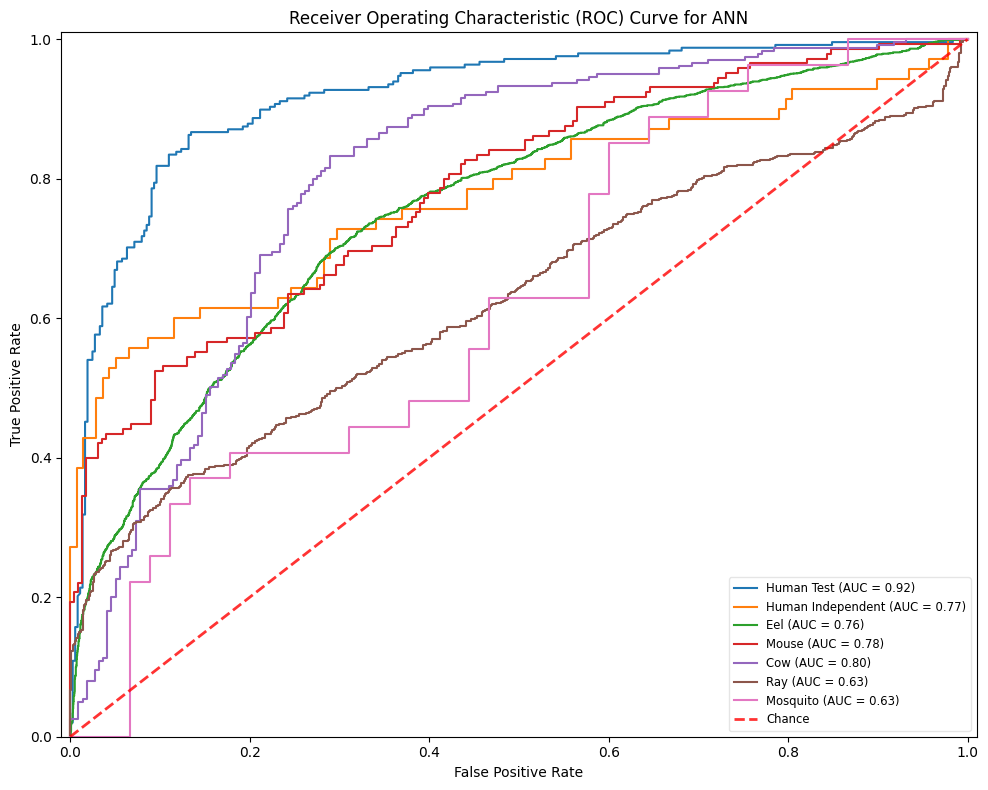

Evaluating dataset: Human Test
Evaluating model: CNN
20/20 [==============================] - 0s 2ms/step
Confusion Matrix - CNN:
[320  44]
[ 58 190]
Model: CNN
Accuracy: 0.8333333333333334
Precision: 0.811965811965812
Recall: 0.7661290322580645
F1 Score: 0.7883817427385892
ROC-AUC Score: 0.8936713488124778
Cohen's Kappa Score: 0.6511066398390342
MCC Score: 0.6518544838037078

Evaluating dataset: Human Independent
Evaluating model: CNN
7/7 [==============================] - 0s 17ms/step
Confusion Matrix - CNN:
[97 41]
[31 39]
Model: CNN
Accuracy: 0.6538461538461539
Precision: 0.4875
Recall: 0.5571428571428572
F1 Score: 0.52
ROC-AUC Score: 0.6816770186335405
Cohen's Kappa Score: 0.2512000000000001
MCC Score: 0.2525696099444564

Evaluating dataset: Eel
Evaluating model: CNN
171/171 [==============================] - 0s 2ms/step
Confusion Matrix - CNN:
[2455  920]
[1014 1070]
Model: CNN
Accuracy: 0.6457226598278073
Precision: 0.5376884422110553
Recall: 0.5134357005758158
F1 Score: 0.52528

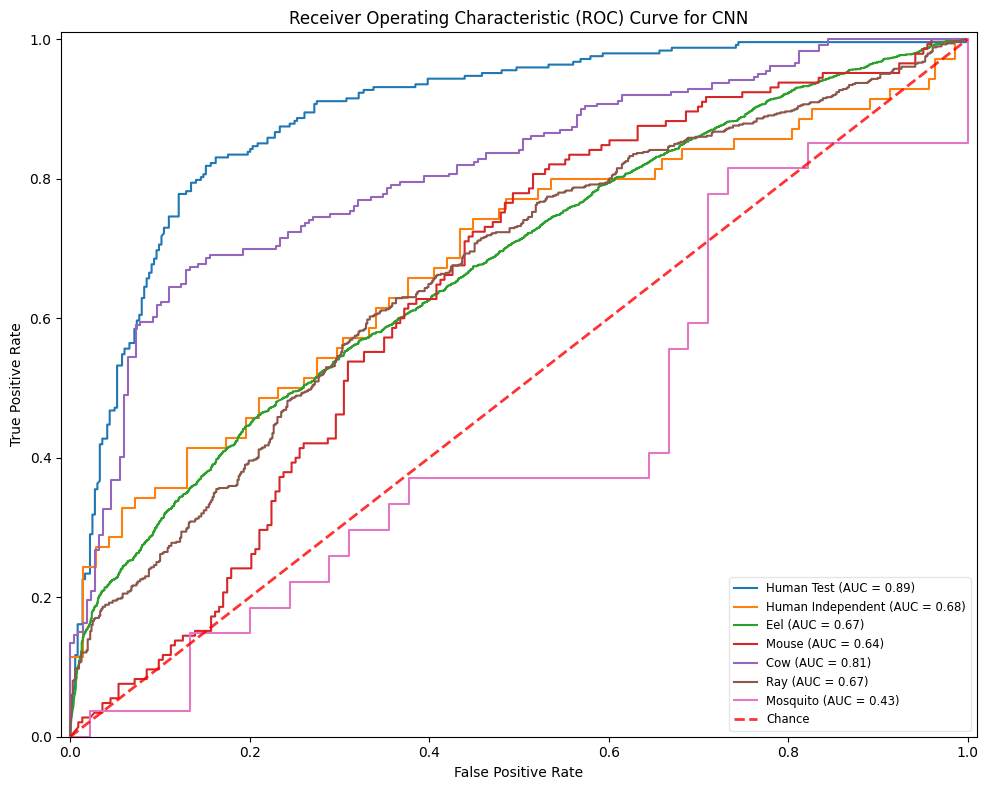

Evaluating dataset: Human Test
Evaluating model: LSTM
20/20 [==============================] - 0s 4ms/step
Confusion Matrix - LSTM:
[264 100]
[ 66 182]
Model: LSTM
Accuracy: 0.7287581699346405
Precision: 0.6453900709219859
Recall: 0.7338709677419355
F1 Score: 0.6867924528301886
ROC-AUC Score: 0.8255992998936548
Cohen's Kappa Score: 0.449330037726031
MCC Score: 0.452215582190856

Evaluating dataset: Human Independent
Evaluating model: LSTM
7/7 [==============================] - 0s 4ms/step
Confusion Matrix - LSTM:
[48 90]
[18 52]
Model: LSTM
Accuracy: 0.4807692307692308
Precision: 0.36619718309859156
Recall: 0.7428571428571429
F1 Score: 0.49056603773584906
ROC-AUC Score: 0.7164596273291925
Cohen's Kappa Score: 0.07234886025768095
MCC Score: 0.09206602719171136

Evaluating dataset: Eel
Evaluating model: LSTM
171/171 [==============================] - 1s 5ms/step
Confusion Matrix - LSTM:
[2140 1235]
[ 758 1326]
Model: LSTM
Accuracy: 0.6349148195640227
Precision: 0.5177664974619289
Recall:

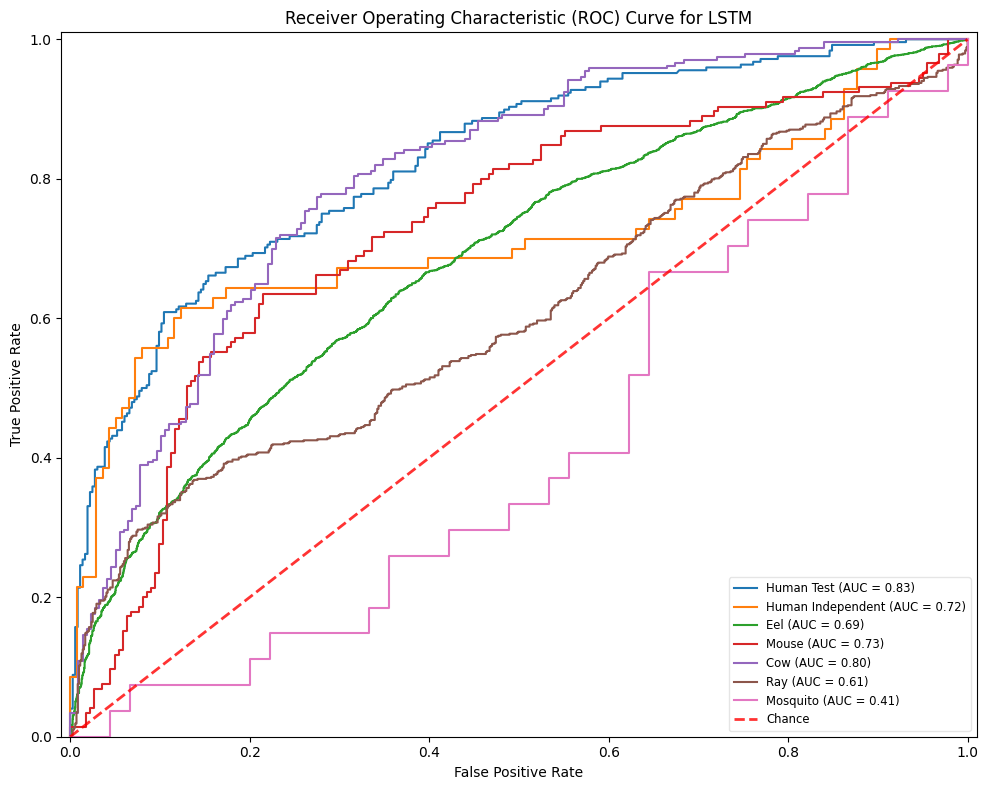

Evaluating dataset: Human Test
Evaluating model: GRU
20/20 [==============================] - 0s 3ms/step
Confusion Matrix - GRU:
[269  95]
[ 55 193]
Model: GRU
Accuracy: 0.7549019607843137
Precision: 0.6701388888888888
Recall: 0.7782258064516129
F1 Score: 0.7201492537313432
ROC-AUC Score: 0.8470788284296349
Cohen's Kappa Score: 0.5042768273716951
MCC Score: 0.5087415345380386

Evaluating dataset: Human Independent
Evaluating model: GRU
7/7 [==============================] - 0s 3ms/step
Confusion Matrix - GRU:
[88 50]
[21 49]
Model: GRU
Accuracy: 0.6586538461538461
Precision: 0.494949494949495
Recall: 0.7
F1 Score: 0.5798816568047337
ROC-AUC Score: 0.7202898550724638
Cohen's Kappa Score: 0.30640616193875636
MCC Score: 0.3194953540438139

Evaluating dataset: Eel
Evaluating model: GRU
171/171 [==============================] - 1s 3ms/step
Confusion Matrix - GRU:
[2433  942]
[ 960 1124]
Model: GRU
Accuracy: 0.6515845392929108
Precision: 0.5440464666021297
Recall: 0.5393474088291746
F1 Sco

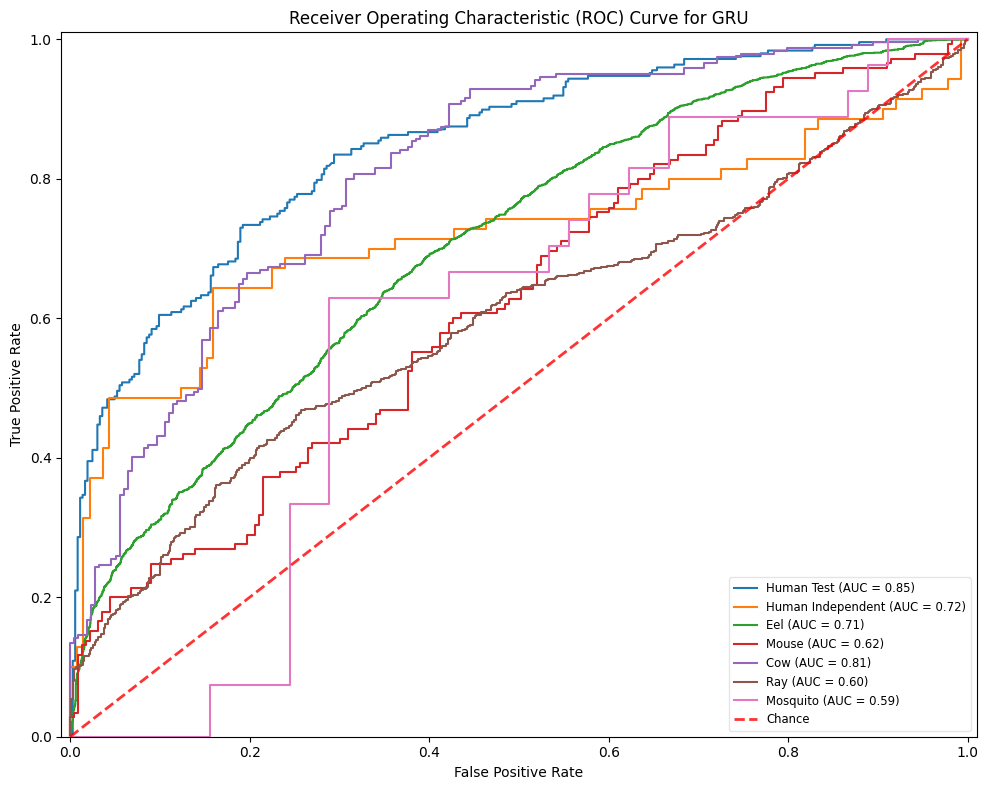

Evaluating dataset: Human Test
Evaluating model: Bi-LSTM
20/20 [==============================] - 0s 4ms/step
Confusion Matrix - Bi-LSTM:
[300  64]
[ 42 206]
Model: Bi-LSTM
Accuracy: 0.826797385620915
Precision: 0.762962962962963
Recall: 0.8306451612903226
F1 Score: 0.7953667953667953
ROC-AUC Score: 0.8889024282169443
Cohen's Kappa Score: 0.645694062131341
MCC Score: 0.6474469453409678

Evaluating dataset: Human Independent
Evaluating model: Bi-LSTM
7/7 [==============================] - 0s 5ms/step
Confusion Matrix - Bi-LSTM:
[79 59]
[21 49]
Model: Bi-LSTM
Accuracy: 0.6153846153846154
Precision: 0.4537037037037037
Recall: 0.7
F1 Score: 0.550561797752809
ROC-AUC Score: 0.7243788819875776
Cohen's Kappa Score: 0.2403214024835647
MCC Score: 0.2576828077596994

Evaluating dataset: Eel
Evaluating model: Bi-LSTM
171/171 [==============================] - 1s 5ms/step
Confusion Matrix - Bi-LSTM:
[2405  970]
[ 779 1305]
Model: Bi-LSTM
Accuracy: 0.6796116504854369
Precision: 0.5736263736263736
R

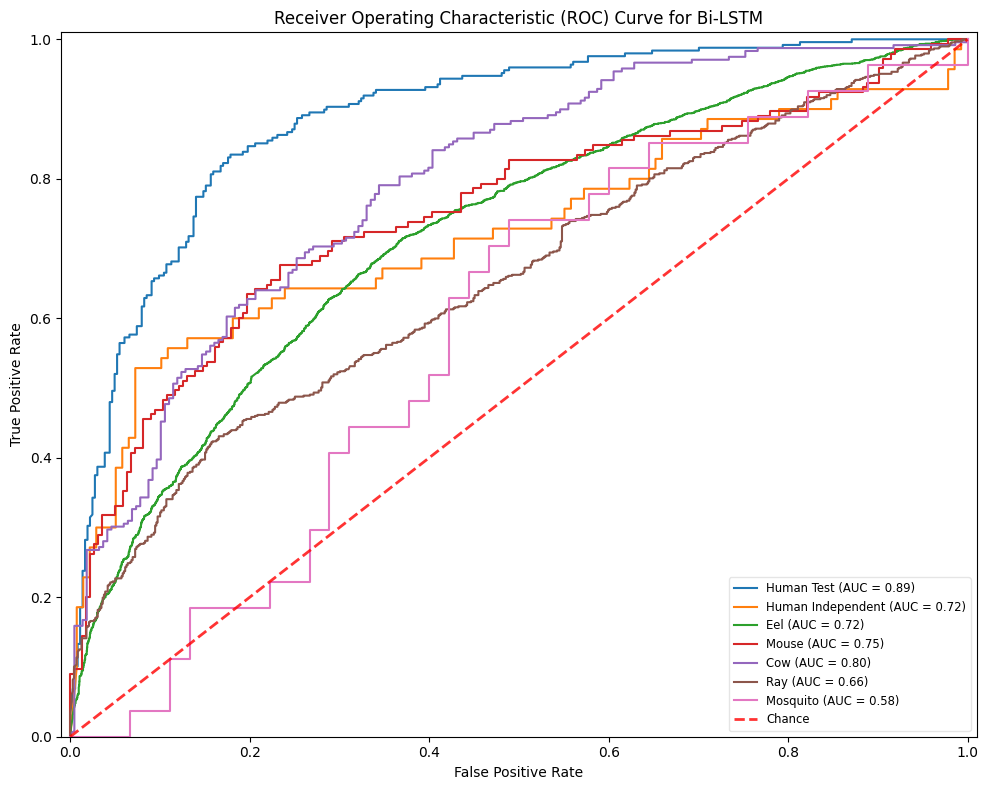

                                                                 ANN  \
Human Test         {'Accuracy': 0.8627450980392157, 'Precision': ...   
Human Independent  {'Accuracy': 0.7451923076923077, 'Precision': ...   
Eel                {'Accuracy': 0.7017768822128595, 'Precision': ...   
Mouse              {'Accuracy': 0.6983695652173914, 'Precision': ...   
Cow                {'Accuracy': 0.7549234135667396, 'Precision': ...   
Ray                {'Accuracy': 0.5945945945945946, 'Precision': ...   
Mosquito           {'Accuracy': 0.6527777777777778, 'Precision': ...   

                                                                 CNN  \
Human Test         {'Accuracy': 0.8333333333333334, 'Precision': ...   
Human Independent  {'Accuracy': 0.6538461538461539, 'Precision': ...   
Eel                {'Accuracy': 0.6457226598278073, 'Precision': ...   
Mouse              {'Accuracy': 0.6059782608695652, 'Precision': ...   
Cow                {'Accuracy': 0.7614879649890591, 'Precision'

/usr/local/lib/python3.10/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

# Define a function to print the confusion matrix as text
def print_confusion_matrix(confusion, model_name):
    print(f"Confusion Matrix - {model_name}:")
    for row in confusion:
        print(row)

# Define a function to plot ROC AUC curve
def plot_roc_auc(y_true, y_score, model_name, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{dataset_name} (AUC = {roc_auc:.2f})')

datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent_optimized_final,
    'Eel': df_eel_optimized_final,
    'Mouse': df_mouse_optimized_final,
    'Cow': df_cow_optimized_final,
    'Ray': df_ray_optimized_final,
    'Mosquito': df_mosquito_optimized_final
}

models = {
    'ANN': ann_model,
    'CNN': cnn_model,
    'LSTM': lstm_model,
    'GRU': gru_model,
    'Bi-LSTM': bi_lstm_model
}

# Evaluate and store results for all datasets
all_results = {}
confusion_matrices = {}

for model_name in models.keys():
    plt.figure(figsize=(10, 8))  # Increase figure size

    for dataset_name, dataset in datasets.items():
        print(f"Evaluating dataset: {dataset_name}")

        # Use StandardScaler to scale your features
        scaler = StandardScaler()
        X = scaler.fit_transform(dataset.loc[:, 'MaxEStateIndex':])
        y = dataset['single-class-label']

        print(f"Evaluating model: {model_name}")

        # Reshape input data for RNN models
        if 'LSTM' in model_name or 'GRU' in model_name:
            X_rnn = X.reshape(X.shape[0], X.shape[1], 1)
        else:
            X_rnn = X

        model = models[model_name]
        y_pred_prob = model.predict(X_rnn)
        y_pred = np.argmax(y_pred_prob, axis=1)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred_prob[:, 1])
        cohen_kappa = cohen_kappa_score(y, y_pred)
        mcc = matthews_corrcoef(y, y_pred)

        # Calculate the confusion matrix
        confusion = confusion_matrix(y, y_pred)

        # Store confusion matrix
        confusion_matrices[(dataset_name, model_name)] = confusion

        # Print the confusion matrix as text
        print_confusion_matrix(confusion, model_name)

        # Print evaluation metrics
        print(f"Model: {model_name}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("ROC-AUC Score:", roc_auc)
        print("Cohen's Kappa Score:", cohen_kappa)
        print("MCC Score:", mcc)
        print()

        # Plot ROC-AUC curve
        plot_roc_auc(y, y_pred_prob[:, 1], model_name, dataset_name)

        # Store results
        if model_name not in all_results:
            all_results[model_name] = {}
        all_results[model_name][dataset_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC-AUC': roc_auc,
            'Cohen\'s Kappa': cohen_kappa,
            'MCC': mcc
        }

    # Plot settings
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim([-0.01, 1.01])
    plt.ylim([0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend(loc="lower right", fontsize='small', fancybox=True, framealpha=0.5)
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f'roc_auc_curve_{model_name}.png')
    plt.show()
    plt.close()

# Create a Pandas DataFrame from the results
results_df = pd.DataFrame(all_results)
print(results_df)

# Save results to Excel
results_df.to_excel('deep_learning_evaluation_results.xlsx', index=True)

# Save confusion matrices to a separate Excel file
with pd.ExcelWriter('confusion_matrices.xlsx') as writer:
    for (dataset_name, model_name), confusion_matrix in confusion_matrices.items():
        df_confusion = pd.DataFrame(confusion_matrix)
        df_confusion.to_excel(writer, sheet_name=f'{dataset_name}_{model_name}_confusion_matrix', index=False)


###Cross Species Evaluation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent_optimized_final,
    'Eel': df_eel_optimized_final,
    'Mouse': df_mouse_optimized_final,
    'Cow': df_cow_optimized_final,
    'Ray': df_ray_optimized_final,
    'Mosquito': df_mosquito_optimized_final
}

models = {
    'ANN': ann_model,
    'CNN': cnn_model,
    'LSTM': lstm_model,
    'GRU': gru_model,
    'Bi-LSTM': bi_lstm_model
}

# Evaluate and store results for all datasets
for model_name, model in models.items():
    model_results = {}
    for dataset_name, dataset in datasets.items():
        print(f"Evaluating dataset: {dataset_name}")

        # Use StandardScaler to scale your features
        scaler = StandardScaler()
        X = scaler.fit_transform(dataset.loc[:, 'MaxEStateIndex':])
        y = dataset['single-class-label']

        print(f"Evaluating model: {model_name}")

        # Reshape input data for RNN models
        if 'LSTM' in model_name or 'GRU' in model_name:
            X_rnn = X.reshape(X.shape[0], X.shape[1], 1)
        else:
            X_rnn = X

        y_pred_prob = model.predict(X_rnn)
        y_pred = np.argmax(y_pred_prob, axis=1)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred_prob[:, 1])
        cohen_kappa = cohen_kappa_score(y, y_pred)
        mcc = matthews_corrcoef(y, y_pred)

        # Store results
        model_results[dataset_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC-AUC': roc_auc,
            'Cohen\'s Kappa': cohen_kappa,
            'MCC': mcc
        }

    # Create a Pandas DataFrame from the results
    results_df = pd.DataFrame(model_results)

    # Save results to Excel
    results_df.to_excel(f'{model_name}_evaluation_results.xlsx', index=True)


Evaluating dataset: Human Test
Evaluating model: ANN
20/20 [==============================] - 0s 1ms/step
Evaluating dataset: Human Independent
Evaluating model: ANN
7/7 [==============================] - 0s 2ms/step
Evaluating dataset: Eel
Evaluating model: ANN
171/171 [==============================] - 0s 1ms/step
Evaluating dataset: Mouse
Evaluating model: ANN
12/12 [==============================] - 0s 1ms/step
Evaluating dataset: Cow
Evaluating model: ANN
15/15 [==============================] - 0s 1ms/step
Evaluating dataset: Ray
Evaluating model: ANN
44/44 [==============================] - 0s 1ms/step
Evaluating dataset: Mosquito
Evaluating model: ANN
3/3 [==============================] - 0s 2ms/step
Evaluating dataset: Human Test
Evaluating model: CNN
20/20 [==============================] - 0s 2ms/step
Evaluating dataset: Human Independent
Evaluating model: CNN
7/7 [==============================] - 0s 2ms/step
Evaluating dataset: Eel
Evaluating model: CNN
171/171 [=========

In [ ]:
models = {
    'ANN': ann_model,
    'CNN': cnn_model,
    'LSTM': lstm_model,
    'GRU': gru_model,
    'Bi-LSTM': bi_lstm_model
}
for model_name, model in models.items():
  model.save(f'{model_name}.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Referenes
*  Muthukrishnan, R., & Rohini, R. (2016). LASSO: A feature selection technique in predictive modeling for machine learning. 2016 IEEE International Conference on Advances in Computer Applications (ICACA), 18–20. https://doi.org/10.1109/ICACA.2016.7887916
*   Rdkit.Chem.Descriptors module. (2024). RDKiT. https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html
* https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html
*   Vignaux, P. A., Lane, T. R., Urbina, F., Gerlach, J., Puhl, A. C., Snyder, S. H., & Ekins, S. (2023). Validation of Acetylcholinesterase Inhibition Machine Learning Models for Multiple Species. Chemical Research in Toxicology, 36(2), 188–201. https://doi.org/10.1021/acs.chemrestox.2c00283